# NHL Expected Goals Model

This notebook will look to create a predictive model using xGBoost to predict the liklihood of a goal occuring on a shot. Using data from 10 NHL seasons, I will look to emulate EvolvingWild's xGoal model using Polars and Pandas (rather than R). I want to give them full credit for the idea of building this model. Their model was built out in R and I wanted to better my skills using Polars, Pandas, and Python using their methodology. I also want to credit Evolving Wild with their incredible ability to pique my interest in building a model of this sort as they are wonderful content creators and ask/answer great questions from the NHL analytic community. The methodology of building this model is heavily based on thier methodology (with some additions from myself) and I do not want to take credit for their work without seriously crediting them. This notebook is essentially a way for me to better my skills in different languages and should be considered a translation of their model from R into Python.


Please read their fantastic article [here](https://evolving-hockey.com/blog/a-new-expected-goals-model-for-predicting-goals-in-the-nhl/) to learn more about their methodology.

In [1]:
from requirements import *
from model_load_functions import clean_pbp_data, index_input_data, split_by_strength, model_prep, imp_sec_type

# 1) Load NHL Play By Play Data

Here, I will use functions from "model_load_functions.py" to clean the raw pbp data stored in my data repository. The final product will be a polars dataframe that I will then use to train and test an xGBoost classification model, thus creating expected goal percentages for each shot.

## *a) Identify Constants (Keys for Events, Game States and Rosters)*

In [2]:
### Constant Values: ###
print("="*25, "Loading Constant Variables: Event_Type Lists, Strength Codes, and Rosters", "="*25)
print("")
print("="*50, "Loading Event Type Vectors", "="*50)

# Event Type Classification #
xG_Events = ['GOAL', 'SHOT', 'MISSED_SHOT', 'BLOCKED_SHOT', 'FACEOFF', 'TAKEAWAY', 'GIVEAWAY', 'HIT']
fenwick_events = ['SHOT', 'GOAL', 'MISSED_SHOT']
corsi_events = ['SHOT', 'GOAL', 'MISSED_SHOT', 'BLOCKED_SHOT']
print(f"xG Event Types (xG_Events): {xG_Events}")
print(f"Fenwick Event Types (fenwick_events): {fenwick_events}")
print(f"Corsi Event Types (corsi_events): {corsi_events}")
print("")
print("="*50, "Loading Strength State Vectors", "="*50)

# Strength States #
EV_STR_Codes = ['5v5', '4v4', '3v3']
PP_STR_Codes = ["5v4", "4v5", "5v3", "3v5", "4v3", "3v4"]
UE_STR_Codes = ["5v4", "4v5", "5v3", "3v5", "4v3", "3v4", "5vE", "Ev5", "4vE", "Ev4", "3vE", "Ev3"]
SH_STR_Codes = ['5v6', '4v5', '3v4', '4v6']
print(f"Even Strength Type Codes (EV_STR_Codes): {EV_STR_Codes}")
print(f"Power-Play Strength Type Codes (PP_STR_Codes): {PP_STR_Codes}")
print(f"Shorthanded Strength Type Codes (SH_STR_Codes): {SH_STR_Codes}")
print("")
print("="*50, "Rosters", "="*50)

# Rosters #
roster_file = 'https://github.com/twinfield10/NHL-Data/raw/main/Rosters/parquet/NHL_Slim_Roster_2010_2024.parquet'
ROSTER_DF_RAW = pl.read_parquet(roster_file)
ROSTER_DF = (
    ROSTER_DF_RAW
    .rename({"id": "event_player_1_id"})
    .select(['event_player_1_id',
             (pl.col("firstName").str.to_uppercase() + '.' + pl.col("lastName").str.to_uppercase()).alias('event_goalie_name'),
             'hand_R', 'hand_L', 'pos_F', 'pos_D', 'pos_G'])
    .unique()
)
print(f"Successfully Loaded All NHL Rosters From 2010 to 2024 from {roster_file}")
print("All Player (Skaters + Goalies) DataFrame:")
print(ROSTER_DF.head())
print("")

# Create Goalie DF
GOALIES = (
    ROSTER_DF_RAW
    .filter(pl.col('pos_G') == 1)
    .select('id',
        (pl.col("firstName").str.to_uppercase() + '.' + pl.col("lastName").str.to_uppercase()).alias('event_goalie_name'),
        'hand_R', 'hand_L'
    )
)
GOALIES.columns = ['event_goalie_id', 'event_goalie_name', 'G_hand_R', 'G_hand_L']
print("Goalie Specific DataFrame: ")
print(GOALIES.head())

========================= Loading Constant Variables: Event_Type Lists, Strength Codes, and Rosters =========================

================================================== Loading Event Type Vectors ==================================================
xG Event Types (xG_Events): ['GOAL', 'SHOT', 'MISSED_SHOT', 'BLOCKED_SHOT', 'FACEOFF', 'TAKEAWAY', 'GIVEAWAY', 'HIT']
Fenwick Event Types (fenwick_events): ['SHOT', 'GOAL', 'MISSED_SHOT']
Corsi Event Types (corsi_events): ['SHOT', 'GOAL', 'MISSED_SHOT', 'BLOCKED_SHOT']

================================================== Loading Strength State Vectors ==================================================
Even Strength Type Codes (EV_STR_Codes): ['5v5', '4v4', '3v3']
Power-Play Strength Type Codes (PP_STR_Codes): ['5v4', '4v5', '5v3', '3v5', '4v3', '3v4']
Shorthanded Strength Type Codes (SH_STR_Codes): ['5v6', '4v5', '3v4', '4v6']

================================================== Rosters ==================================================

## *b) Load Raw(ish) Play-By-Play Data From NHL API via NHL-Data Repository*

This cell will load each season of data, apply our cleaning and splitting functions, and then append all seasons of data to build our 4 dataframes for training and testing a model.

*Note: I have mostly followed the same methodology as Evolving Wild up to this point. However I wanted to test the difference in their assumption of using only 7 years of PBP data for EV and PP models. Since Polars can be more efficient with large datasets like this, there was not much difference in performace of loading and training models on 10 years of data compared to 7.*

In [3]:
# Initialize an empty list to store the dataframes
ev_dfs = []
pp_dfs = []
sh_dfs = []
en_dfs = []
season_list = [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

print("================== Begin Loading + Cleaning Individual Seasons via TW SCRAPE ==================")
print(" ")

for i in season_list:
    # Print Season Label
    print(f"Now Loading Play by Play Data From {i} NHL Season")
    
    # Basic Clean/Manipulation
    df = clean_pbp_data(pl.read_parquet(f"https://github.com/twinfield10/NHL-Data/raw/main/PBP/parquet/API_RAW_PBP_Data_{i}.parquet"))

    # Create Indexes
    df = index_input_data(df)

    # Split by Strength
    ev, pp, sh, en = split_by_strength(df)

    # Prep For Model (OHE + Other Features)
    ev = model_prep(ev, "EV")
    pp = model_prep(pp, "PP")
    sh = model_prep(sh, "SH")
    en = model_prep(en, "EN")

    # Append the modified dataframe to the list
    ev_dfs.append(ev)
    pp_dfs.append(pp)
    sh_dfs.append(sh)
    en_dfs.append(en)

    # Create the PBP DataFrames
print(" ")
print("================== Begin Appending DataFrames Together ==================")
print(" ")

# EV
EV_PBP = ev_dfs[1]
for df in ev_dfs[2:]:
    EV_PBP = EV_PBP.extend(df)
print(str(EV_PBP.height) + " Total Shots in Even Strength DF")

# PP
PP_PBP = pp_dfs[0]
for df in pp_dfs[1:]:
    PP_PBP = PP_PBP.extend(df)
print(str(PP_PBP.height) + " Total Shots in Power Play DF")

# SH
SH_PBP = sh_dfs[0]
for df in sh_dfs[1:]:
    SH_PBP = SH_PBP.extend(df)
print(str(SH_PBP.height) + " Total Shots in Short Handed (Offense) DF")

# EN
EN_PBP = en_dfs[0]
for df in en_dfs[1:]:
    EN_PBP = EN_PBP.extend(df)
print(str(EN_PBP.height) + " Total Shots in Empty Net DF")

# Imputate + Clean Null Values of Shot Type
print(" ")
print("================== Begin Imputing Null Shot Type Values ==================")
print(" ")

EV_PBP = imp_sec_type(EV_PBP).drop('event_detail')
PP_PBP = imp_sec_type(PP_PBP).drop('event_detail')
SH_PBP = imp_sec_type(SH_PBP).drop('event_detail')
EN_PBP = imp_sec_type(EN_PBP).drop('event_detail')

print("================== End Loading Data From " + str(EV_PBP['season'].min()) + "-" + str(EV_PBP['season'].max())  + " Seasons ==================")


================== Begin Loading + Cleaning Individual Seasons via TW SCRAPE ==================
 
Now Loading Play by Play Data From 2012 NHL Season
Now Loading Play by Play Data From 2013 NHL Season
Now Loading Play by Play Data From 2014 NHL Season
Now Loading Play by Play Data From 2015 NHL Season
Now Loading Play by Play Data From 2016 NHL Season
Now Loading Play by Play Data From 2017 NHL Season
Now Loading Play by Play Data From 2018 NHL Season
Now Loading Play by Play Data From 2019 NHL Season
Now Loading Play by Play Data From 2020 NHL Season
Now Loading Play by Play Data From 2021 NHL Season
Now Loading Play by Play Data From 2022 NHL Season
Now Loading Play by Play Data From 2023 NHL Season
 
================== Begin Appending DataFrames Together ==================
 
892670 Total Shots in Even Strength DF
195724 Total Shots in Power Play DF
28722 Total Shots in Short Handed (Offense) DF
4362 Total Shots in Empty Net DF
 
================== Begin Imputing Null Shot Type Values

# 2) Build xGBoost Classification Model

## *a) Function: Hypertune, Train, Test, and Evaluate Model*

1. *HyperparameterOptimizer*
    - Here we use Optuna to suggest parameter values and test them after a certain amount of startup trials on a sample of data from our clean play by play data.
        - I use TPE sampler here to set up the inital trials before applying the suggested parameters that stem from the suggested values.
    - This process replaces Evolving Wild's CV Grid Search and I have found hypertuning parameters this way to be faster and more helpful than grid search.
    - *I use Log Loss as the eval metric here to determine which parameters are the "best parameters".*
2. *XGBoostTrainer*
    - Here I am using a binary classification model (xGBoost Classifier) to create a probability that each Corsi Event (Shot, Missed Shot, Goal) results in a goal.
    - Evaluation Metrics used are:
        - ***Log Loss*** **(Primary Eval Metric)**
        - AUC
        - R2
        - Confusion Matrix
        - Classification Report
3. *Feature_Analysis*
    - Evaluating most important features using xGBoost's built in methods (weight, gain, cover)

In [4]:
from model_creation import HyperparameterOptimizer, XGBoostTrainer, Feature_Analysis

## *b) Convert Polars To Pandas + Clean Nulls*

I am chosing to convert my polars DF to pandas here as the code written in the function above deals with Pandas dataframes. This may be altered in the future to be compatable with a Polars dataframe but for now conversion from Polars to Pandas + cleaning a Pandas dataframe is performative enough to be able to do so.

In [5]:
EV_PD = EV_PBP.to_pandas()
PP_PD = PP_PBP.to_pandas()
SH_PD = SH_PBP.to_pandas()
EN_PD = EN_PBP.to_pandas()

### *i) Check and Remove Nulls*  

In [6]:
for df in [EV_PD, PP_PD, SH_PD, EN_PD]:
    # Get the count of null values in each column
    null_counts = df.isnull().sum()
    # Filter columns with count > 0
    filtered_columns = null_counts[null_counts > 0]
    # Show the filtered DataFrame
    print(filtered_columns)

pos_F     7439
pos_D     7439
pos_G     7439
hand_R    7439
hand_L    7439
dtype: int64
pos_F     2572
pos_D     2572
pos_G     2572
hand_R    2572
hand_L    2572
dtype: int64
pos_F     303
pos_D     303
pos_G     303
hand_R    303
hand_L    303
dtype: int64
pos_F     40
pos_D     40
pos_G     40
hand_R    40
hand_L    40
dtype: int64


In [7]:
EV_PD[EV_PD['pos_F'].isnull()].groupby('season').size().reset_index(name='count')

,season,count
0,20132014,712
1,20142015,832
2,20152016,875
3,20162017,760
4,20172018,848
5,20182019,705
6,20192020,602
7,20202021,504
8,20212022,736
9,20222023,697


In [8]:
EV_PD.dropna(how = 'any', inplace = True)
PP_PD.dropna(how = 'any', inplace = True)
SH_PD.dropna(how = 'any', inplace = True)
EN_PD.dropna(how = 'any', inplace = True)

In [9]:
from model_creation import correlation_metrics
correlation_metrics(EV_PD)

Top 10 Correlated Features
                          var1     var2  ABS_Corr_Val Corr_Type
47              event_distance  is_goal      0.149819  Negative
30                       x_abs  is_goal      0.121344  Positive
1328                is_rebound  is_goal      0.102003  Positive
80    event_angle_change_speed  is_goal      0.081124  Positive
173                      pos_F  is_goal      0.075233  Positive
155      puck_speed_since_last  is_goal      0.067711  Positive
38                       y_abs  is_goal      0.059326  Negative
57                 event_angle  is_goal      0.045667  Negative
1713                  tip_shot  is_goal      0.031537  Positive
353                  state_3v3  is_goal      0.021899  Positive
Bottom 10 Correlated Features
             var1     var2  ABS_Corr_Val Corr_Type
278  shift_length  is_goal      0.000258  Positive
498    score_even  is_goal      0.000493  Positive
530    score_up_1  is_goal      0.000668  Positive
467  score_down_1  is_goal      0.0

## *Even Strength Model - True Sample*

Baseline Goal Percentage: 5.06%
Optimized xGoal XGBoost Classifier R2 on Test Data: 0.010
Optimized xGoal XGBoost Classifier Log Loss on Test Data: 0.190
Optimized xGoal XGBoost Classifier AUC: 0.739
Optimized xGoal XGBoost Classifier Optimal Treshold: 4.68%
Confusion Matrix:
-----------------
[[55858 24557]
 [ 1466  2841]]

Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.97      0.69      0.81     80415
           1       0.10      0.66      0.18      4307

    accuracy                           0.69     84722
   macro avg       0.54      0.68      0.50     84722
weighted avg       0.93      0.69      0.78     84722



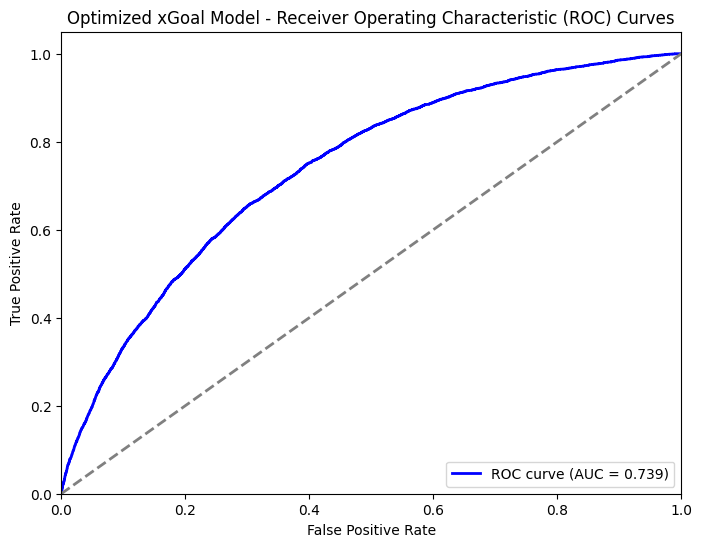

In [16]:
# Split the data into training and testing sets
ev_train_data = EV_PD[EV_PD['season'] != 20232024].sample(frac=0.9, random_state=87)
ev_test_data = EV_PD[EV_PD['season'] != 20232024].drop(ev_train_data.index)

# Print Baseline
print(f"Baseline Goal Percentage: {round((ev_train_data['is_goal'].sum() / ev_train_data['is_goal'].count())*100, 2)}%")

# Define the features, target variable, and cols to exclude
ev_exclude_cols = ['season', 'game_id', 'event_idx']
ev_features = [t_col for t_col in EV_PD.columns if t_col not in ev_exclude_cols and t_col != "is_goal"]

ev_X_train, ev_y_train = ev_train_data[ev_features], ev_train_data["is_goal"]
ev_X_test, ev_y_test = ev_test_data[ev_features], ev_test_data["is_goal"]

# Identify Baseline Parameters
baseline_params = {'colsample_bytree': 0.9, 'gamma': 0.2, 'max_depth': 5, 'learning_rate': 0.55, 'min_child_weight': 5, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.9, 'n_estimators': 700}

# Train Baseline Model
xgboost_trainer = XGBoostTrainer()
ev_baseline_model_sample, ev_y_pred_sample, ev_logloss_sample, ev_auc_sample, ev_OT_sample = xgboost_trainer.train_and_evaluate_xgboost(ev_X_train, ev_y_train, ev_X_test, ev_y_test, baseline_params)

## *Man-Advantage Model - True Sample*

Baseline Goal Percentage: 7.95%
Optimized xGoal XGBoost Classifier R2 on Test Data: 0.030
Optimized xGoal XGBoost Classifier Log Loss on Test Data: 0.265
Optimized xGoal XGBoost Classifier AUC: 0.694
Optimized xGoal XGBoost Classifier Optimal Treshold: 7.77%
Confusion Matrix:
-----------------
[[17031  8411]
 [  851  1370]]

Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.95      0.67      0.79     25442
           1       0.14      0.62      0.23      2221

    accuracy                           0.67     27663
   macro avg       0.55      0.64      0.51     27663
weighted avg       0.89      0.67      0.74     27663



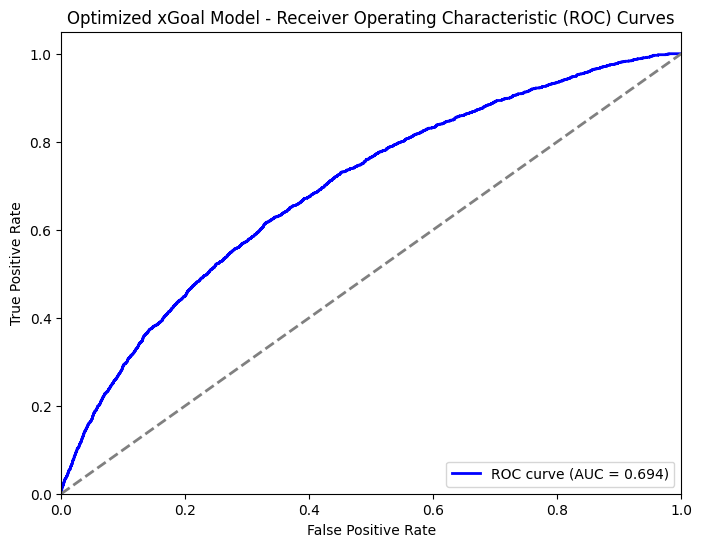

In [17]:
# Split the data into training and testing sets
pp_train_data = PP_PD[PP_PD['season'] != 20232024].sample(frac=0.85, random_state=87)
pp_test_data = PP_PD[PP_PD['season'] != 20232024].drop(pp_train_data.index)

# Print Baseline
print(f"Baseline Goal Percentage: {round((pp_train_data['is_goal'].sum() / pp_train_data['is_goal'].count())*100, 2)}%")

# Define the features, target variable, and cols to exclude
pp_exclude_cols = ['season', 'game_id', 'event_idx']
pp_features = [t_col for t_col in PP_PD.columns if t_col not in pp_exclude_cols and t_col != "is_goal"]

pp_X_train, pp_y_train = pp_train_data[pp_features], pp_train_data["is_goal"]
pp_X_test, pp_y_test = pp_test_data[pp_features], pp_test_data["is_goal"]

# Manually Identify BASELINE Params if Session Stops
baseline_params = {'colsample_bytree': 1, 'gamma': 0, 'max_depth': 5, 'min_child_weight': 1, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1, 'n_estimators': 250}

# Train Baseline Model
xgboost_trainer = XGBoostTrainer()
pp_baseline_model_sample, pp_y_pred_sample, pp_logloss_sample, pp_auc_sample, pp_OT_sample = xgboost_trainer.train_and_evaluate_xgboost(pp_X_train, pp_y_train, pp_X_test, pp_y_test, baseline_params)

## *Short Handed Model - True Sample*

Baseline Goal Percentage: 6.33%
Optimized xGoal XGBoost Classifier R2 on Test Data: -0.040
Optimized xGoal XGBoost Classifier Log Loss on Test Data: 0.251
Optimized xGoal XGBoost Classifier AUC: 0.744
Optimized xGoal XGBoost Classifier Optimal Treshold: 0.9%
Confusion Matrix:
-----------------
[[2738 2345]
 [  54  291]]

Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.98      0.54      0.70      5083
           1       0.11      0.84      0.20       345

    accuracy                           0.56      5428
   macro avg       0.55      0.69      0.45      5428
weighted avg       0.93      0.56      0.66      5428



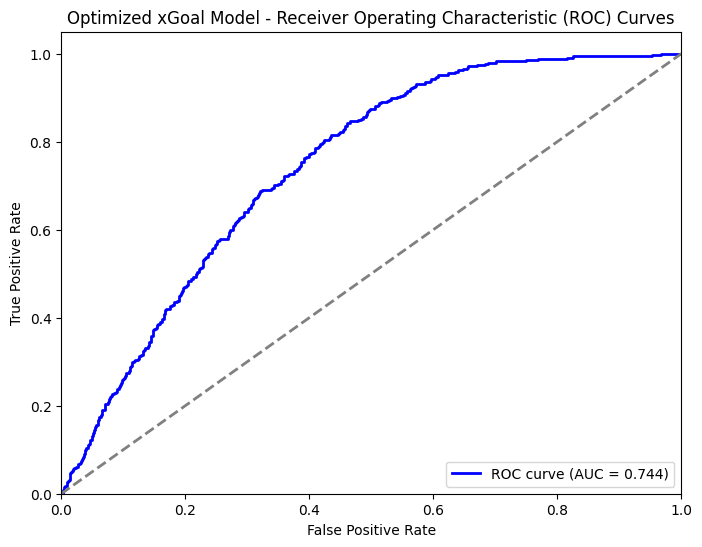

In [18]:
# Split the data into training and testing sets
sh_train_data = SH_PD[SH_PD['season'] != 20232024].sample(frac=0.8, random_state=87)
sh_test_data = SH_PD[SH_PD['season'] != 20232024].drop(sh_train_data.index)

# Print Baseline
print(f"Baseline Goal Percentage: {round((sh_train_data['is_goal'].sum() / sh_train_data['is_goal'].count())*100, 2)}%")

# Define the features, target variable, and cols to exclude
sh_exclude_cols = ['season', 'game_id', 'event_idx']
sh_features = [t_col for t_col in SH_PD.columns if t_col not in sh_exclude_cols and t_col != "is_goal"]

sh_X_train, sh_y_train = sh_train_data[sh_features], sh_train_data["is_goal"]
sh_X_test, sh_y_test = sh_test_data[sh_features], sh_test_data["is_goal"]

# Manually Identify BASELINE Params if Session Stops
baseline_params = {'colsample_bytree': 1, 'gamma': 0, 'max_depth': 5, 'min_child_weight': 1, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1, 'n_estimators': 250}

# Train Baseline Model
xgboost_trainer = XGBoostTrainer()
sh_baseline_model_sample, sh_y_pred_sample, sh_logloss_sample, sh_auc_sample, sh_OT_sample = xgboost_trainer.train_and_evaluate_xgboost(sh_X_train, sh_y_train, sh_X_test, sh_y_test, baseline_params)

## *Empty Net Model - True Sample*

Baseline Goal Percentage: 4.3%
Optimized xGoal XGBoost Classifier R2 on Test Data: -0.090
Optimized xGoal XGBoost Classifier Log Loss on Test Data: 0.252
Optimized xGoal XGBoost Classifier AUC: 0.587
Optimized xGoal XGBoost Classifier Optimal Treshold: 0.27%
Confusion Matrix:
-----------------
[[825 288]
 [ 22  20]]

Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.97      0.74      0.84      1113
           1       0.06      0.48      0.11        42

    accuracy                           0.73      1155
   macro avg       0.52      0.61      0.48      1155
weighted avg       0.94      0.73      0.82      1155



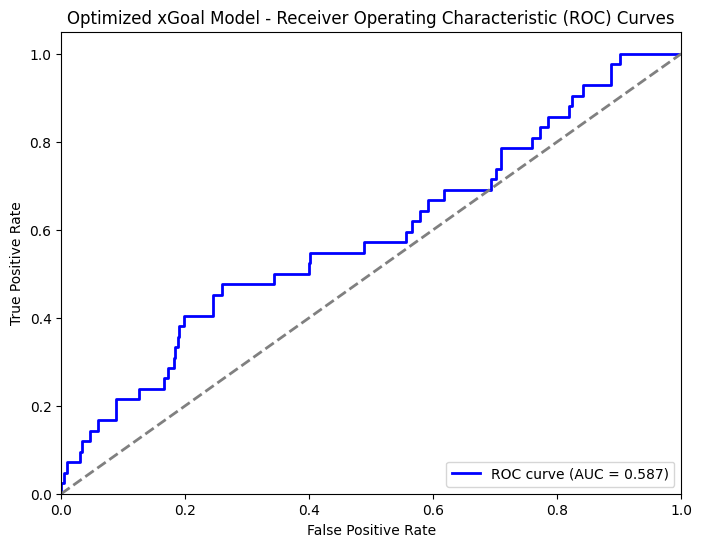

In [27]:
# Split the data into training and testing sets
en_train_data = EN_PD[EN_PD['season'] != 20232024].sample(frac=0.7, random_state=87)
en_test_data = EN_PD[EN_PD['season'] != 20232024].drop(en_train_data.index)

# Print Baseline
print(f"Baseline Goal Percentage: {round((en_train_data['is_goal'].sum() / en_train_data['is_goal'].count())*100, 2)}%")

# Define the features, target variable, and cols to exclude
en_exclude_cols = ['season', 'game_id', 'event_idx']
en_features = [t_col for t_col in EN_PD.columns if t_col not in en_exclude_cols and t_col != "is_goal"]

en_X_train, en_y_train = en_train_data[en_features], en_train_data["is_goal"]
en_X_test, en_y_test = en_test_data[en_features], en_test_data["is_goal"]

# Manually Identify BASELINE Params if Session Stops
baseline_params = {'colsample_bytree': 1, 'gamma': 0, 'max_depth': 5, 'min_child_weight': 1, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1, 'n_estimators': 250}

# Train Baseline Model
xgboost_trainer = XGBoostTrainer()
en_baseline_model_sample, en_y_pred_sample, en_logloss_sample, en_auc_sample, en_OT_sample = xgboost_trainer.train_and_evaluate_xgboost(en_X_train, en_y_train, en_X_test, en_y_test, baseline_params)

## Hypertune Parameters

Here, I want to hypertune my parameters and use the most current data as the test rather than a sample. If hypertuning is able to help the model be more predictive on the most current data (rather than testing against a sample of data that includes 2012-2013 data), then it will likely be more predictive in the future.

In [ ]:
# Optimize hyperparameters
hyperparameter_optimizer = HyperparameterOptimizer(n_startup_trials=10000, n_trials=1000)
alt_hyperparameter_optimizer = HyperparameterOptimizer(n_startup_trials=1000, n_trials=100)

In [14]:
# Even Strength
print("Begin Even Strength Hypertuning")
ev_best_params, ev_param_df = alt_hyperparameter_optimizer.optimize_hyperparameters(ev_X_train, ev_y_train, ev_X_test, ev_y_test, type = 'EV')

[I 2024-01-05 13:55:36,443] A new study created in memory with name: XGBoost Classification Optimization


Begin Even Strength Hypertuning


[I 2024-01-05 13:56:20,969] Trial 0 finished with value: 0.18139062322456778 and parameters: {'max_depth': 5, 'learning_rate': 0.042245523022493285, 'n_estimators': 537, 'min_child_weight': 3, 'reg_alpha': 3, 'reg_lambda': 7, 'gamma': 0.022933419449232367, 'seed': 87, 'max_delta_step': 3, 'colsample_bytree': 0.8031563506568716, 'subsample': 0.8236301153886283}. Best is trial 0 with value: 0.18139062322456778.
[I 2024-01-05 13:57:28,499] Trial 1 finished with value: 0.18164096531582846 and parameters: {'max_depth': 6, 'learning_rate': 0.055913900898354796, 'n_estimators': 629, 'min_child_weight': 4, 'reg_alpha': 7, 'reg_lambda': 5, 'gamma': 0.02515492267253142, 'seed': 87, 'max_delta_step': 5, 'colsample_bytree': 0.8103691598210261, 'subsample': 0.7938541520125385}. Best is trial 0 with value: 0.18139062322456778.
[I 2024-01-05 13:58:18,754] Trial 2 finished with value: 0.1814322405662264 and parameters: {'max_depth': 6, 'learning_rate': 0.043236102156431484, 'n_estimators': 549, 'min_c

Best EV hyperparameters: %s {'max_depth': 6, 'learning_rate': 0.04466000000809512, 'n_estimators': 606, 'min_child_weight': 5, 'reg_alpha': 4, 'reg_lambda': 4, 'gamma': 0.02872199927499311, 'seed': 87, 'max_delta_step': 3, 'colsample_bytree': 0.809593142056648, 'subsample': 0.8151921940151409}
Begin Man Advantage Hypertuning
Begin Shorthanded Hypertuning
Begin Empty Net Hypertuning


In [15]:
ev_param_df.sort_values('value').head(20)

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_gamma,params_learning_rate,params_max_delta_step,params_max_depth,params_min_child_weight,params_n_estimators,params_reg_alpha,params_reg_lambda,params_seed,params_subsample,state
52,52,0.181375,2024-01-05 14:52:32.283944,2024-01-05 14:53:28.054340,0 days 00:00:55.770396,0.809593,0.028722,0.044660,3,6,5,606,4,4,87,0.815192,COMPLETE
0,0,0.181391,2024-01-05 13:55:36.444109,2024-01-05 13:56:20.968382,0 days 00:00:44.524273,0.803156,0.022933,0.042246,3,5,3,537,3,7,87,0.823630,COMPLETE
29,29,0.181402,2024-01-05 14:29:10.964846,2024-01-05 14:29:59.838200,0 days 00:00:48.873354,0.831877,0.026527,0.047003,5,6,3,513,6,5,87,0.729592,COMPLETE
25,25,0.181405,2024-01-05 14:24:13.612039,2024-01-05 14:25:30.822139,0 days 00:01:17.210100,0.816885,0.014099,0.041618,3,5,4,791,3,3,87,0.834053,COMPLETE
14,14,0.181408,2024-01-05 14:09:51.784660,2024-01-05 14:11:01.925677,0 days 00:01:10.141017,0.833379,0.021611,0.045378,3,5,3,741,5,4,87,0.817192,COMPLETE
64,64,0.181414,2024-01-05 15:04:33.305982,2024-01-05 15:05:39.304611,0 days 00:01:05.998629,0.834967,0.013397,0.041327,4,6,4,645,6,6,87,0.779515,COMPLETE
32,32,0.181423,2024-01-05 14:32:11.335508,2024-01-05 14:33:13.953524,0 days 00:01:02.618016,0.836201,0.029421,0.047665,5,6,5,604,6,4,87,0.774523,COMPLETE
65,65,0.181426,2024-01-05 15:05:39.306524,2024-01-05 15:06:44.409212,0 days 00:01:05.102688,0.809701,0.014126,0.042587,4,5,5,776,6,7,87,0.818701,COMPLETE
2,2,0.181432,2024-01-05 13:57:28.500438,2024-01-05 13:58:18.754839,0 days 00:00:50.254401,0.843525,0.012763,0.043236,5,6,5,549,7,5,87,0.753622,COMPLETE
92,92,0.181433,2024-01-05 15:31:49.752463,2024-01-05 15:32:47.250150,0 days 00:00:57.497687,0.805354,0.019804,0.045413,4,6,5,532,5,4,87,0.719520,COMPLETE


In [ ]:
# Power Play
print("Begin Man Advantage Hypertuning")
pp_best_params, pp_param_df = hyperparameter_optimizer.optimize_hyperparameters(pp_X_train, pp_y_train, pp_X_test, pp_y_test, type = 'PP')
pp_param_df.sort_values('value').head(20)

In [17]:
# SH
print("Begin Shorthanded Hypertuning")
sh_best_params, sh_param_df = alt_hyperparameter_optimizer.optimize_hyperparameters(sh_X_train, sh_y_train, sh_X_test, sh_y_test, type = 'SH')
sh_param_df.sort_values('value').head(20)

[I 2024-01-05 16:02:33,884] A new study created in memory with name: XGBoost Classification Optimization


Begin Shorthanded Hypertuning


[I 2024-01-05 16:02:38,133] Trial 0 finished with value: 0.20884438926615137 and parameters: {'max_depth': 3, 'learning_rate': 0.026010048670428804, 'n_estimators': 742, 'min_child_weight': 5.882433509472853, 'reg_alpha': 2, 'reg_lambda': 3, 'gamma': 0.37655596105219014, 'seed': 87, 'max_delta_step': 5, 'colsample_bytree': 0.8349886488895242, 'subsample': 0.7816383480513258}. Best is trial 0 with value: 0.20884438926615137.
[I 2024-01-05 16:02:42,194] Trial 1 finished with value: 0.20937999049541656 and parameters: {'max_depth': 6, 'learning_rate': 0.02160448019800757, 'n_estimators': 401, 'min_child_weight': 4.267056524311801, 'reg_alpha': 6, 'reg_lambda': 0, 'gamma': 0.41082163044057013, 'seed': 87, 'max_delta_step': 5, 'colsample_bytree': 0.8240929712852462, 'subsample': 0.8481800247211486}. Best is trial 0 with value: 0.20884438926615137.
[I 2024-01-05 16:02:49,629] Trial 2 finished with value: 0.21589954534001568 and parameters: {'max_depth': 6, 'learning_rate': 0.0248818656348750

Best SH hyperparameters: %s {'max_depth': 3, 'learning_rate': 0.02436237563165397, 'n_estimators': 467, 'min_child_weight': 2.4195664707994373, 'reg_alpha': 0, 'reg_lambda': 1, 'gamma': 0.2696551343955971, 'seed': 87, 'max_delta_step': 5, 'colsample_bytree': 0.8375013096643003, 'subsample': 0.7633378780198586}


,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_gamma,params_learning_rate,params_max_delta_step,params_max_depth,params_min_child_weight,params_n_estimators,params_reg_alpha,params_reg_lambda,params_seed,params_subsample,state
65,65,0.207707,2024-01-05 16:06:37.119928,2024-01-05 16:06:38.777953,0 days 00:00:01.658025,0.837501,0.269655,0.024362,5,3,2.419566,467,0,1,87,0.763338,COMPLETE
8,8,0.207779,2024-01-05 16:03:17.827880,2024-01-05 16:03:19.415414,0 days 00:00:01.587534,0.810211,0.593307,0.027240,5,3,0.328585,318,1,2,87,0.834332,COMPLETE
21,21,0.207815,2024-01-05 16:04:12.063775,2024-01-05 16:04:14.688781,0 days 00:00:02.625006,0.822790,0.124267,0.010910,5,3,3.666196,676,1,1,87,0.821255,COMPLETE
12,12,0.207844,2024-01-05 16:03:35.593049,2024-01-05 16:03:39.134316,0 days 00:00:03.541267,0.827081,0.218760,0.013202,5,3,2.009258,677,3,0,87,0.835093,COMPLETE
62,62,0.208121,2024-01-05 16:06:25.061336,2024-01-05 16:06:27.538031,0 days 00:00:02.476695,0.817766,0.274035,0.010420,5,4,3.201945,522,1,3,87,0.803606,COMPLETE
90,90,0.208215,2024-01-05 16:07:50.753543,2024-01-05 16:07:52.926391,0 days 00:00:02.172848,0.807622,0.490295,0.014041,5,3,1.634954,586,6,2,87,0.802855,COMPLETE
24,24,0.208224,2024-01-05 16:04:23.066229,2024-01-05 16:04:25.305845,0 days 00:00:02.239616,0.846030,0.411585,0.015785,5,4,5.645079,495,2,3,87,0.769571,COMPLETE
40,40,0.208224,2024-01-05 16:05:19.011909,2024-01-05 16:05:21.000902,0 days 00:00:01.988993,0.843231,0.051729,0.024736,5,5,4.773715,352,4,2,87,0.803720,COMPLETE
98,98,0.208268,2024-01-05 16:08:15.637293,2024-01-05 16:08:19.045563,0 days 00:00:03.408270,0.831792,0.217936,0.012803,5,3,1.506111,909,1,5,87,0.741099,COMPLETE
54,54,0.208282,2024-01-05 16:06:00.979620,2024-01-05 16:06:02.830361,0 days 00:00:01.850741,0.804721,0.143977,0.010429,5,3,3.608118,561,0,5,87,0.847345,COMPLETE


In [28]:
# EN
print("Begin Empty Net Hypertuning")
en_best_params, en_param_df = alt_hyperparameter_optimizer.optimize_hyperparameters(en_X_train, en_y_train, en_X_test, en_y_test, type = 'EN')
en_param_df.sort_values('value').head(20)

Begin Empty Net Hypertuning


NameError: name 'alt_hyperparameter_optimizer' is not defined

## Optimized Even Strength Model

Optimized xGoal XGBoost Classifier R2 on Test Data: 0.060
Optimized xGoal XGBoost Classifier Log Loss on Test Data: 0.175
Optimized xGoal XGBoost Classifier AUC: 0.778
Optimized xGoal XGBoost Classifier Optimal Treshold: 0.050
Confusion Matrix:
-----------------
[[113857  56585]
 [  2304   6846]]

Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.98      0.67      0.79    170442
           1       0.11      0.75      0.19      9150

    accuracy                           0.67    179592
   macro avg       0.54      0.71      0.49    179592
weighted avg       0.94      0.67      0.76    179592



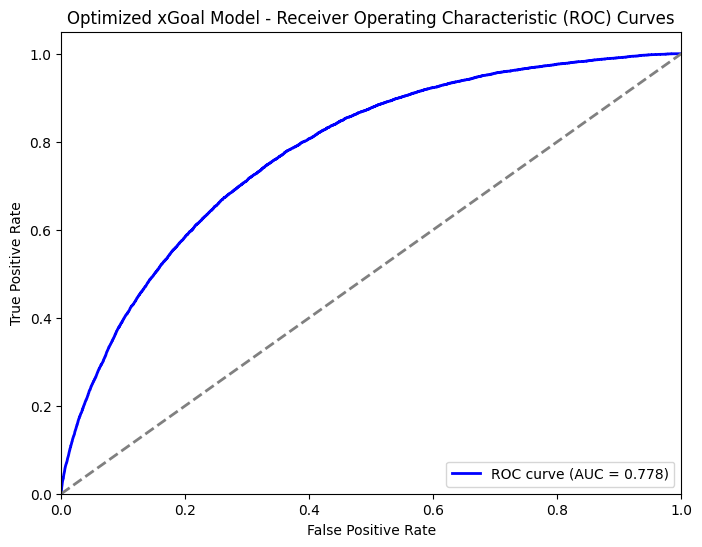

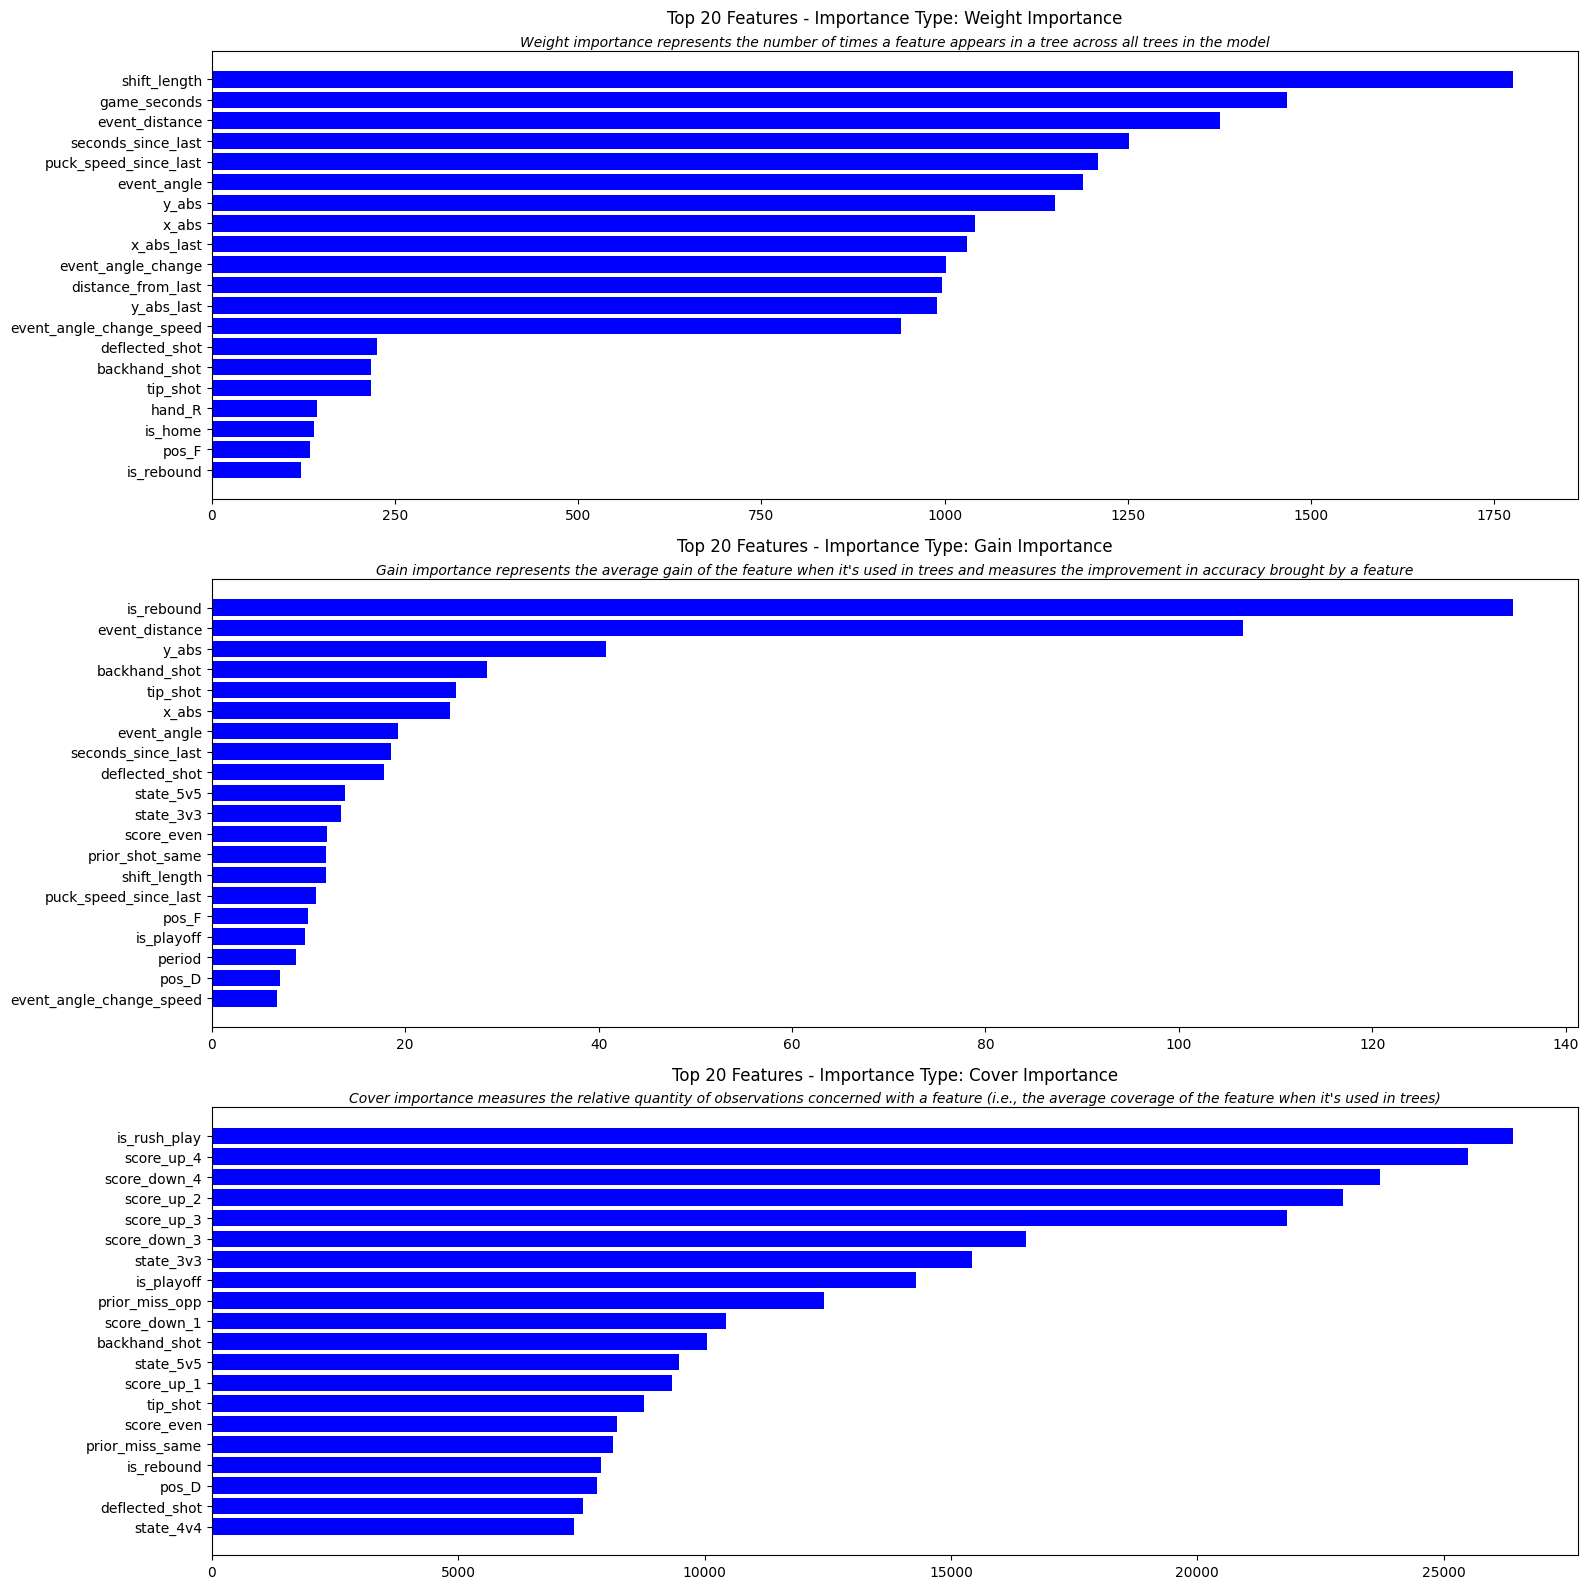

In [77]:
# Train HyperTuned Model
xgboost_trainer = XGBoostTrainer()
best_ev_model, y_pred_ev, best_ev_logloss, best_ev_auc, best_ev_OT = xgboost_trainer.train_and_evaluate_xgboost(ev_X_train, ev_y_train, ev_X_test, ev_y_test, ev_best_params)

# Return Feature Analysis Plot
Feature_Analysis().plot_top_features(best_ev_model, 20)

## Optimized Man-Advantage Model

Optimized xGoal XGBoost Classifier R2 on Test Data: 0.060
Optimized xGoal XGBoost Classifier Log Loss on Test Data: 0.367
Optimized xGoal XGBoost Classifier AUC: 0.703
Optimized xGoal XGBoost Classifier Optimal Treshold: 0.119
Confusion Matrix:
-----------------
[[7831 6143]
 [ 563 1632]]

Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.93      0.56      0.70     13974
           1       0.21      0.74      0.33      2195

    accuracy                           0.59     16169
   macro avg       0.57      0.65      0.51     16169
weighted avg       0.83      0.59      0.65     16169



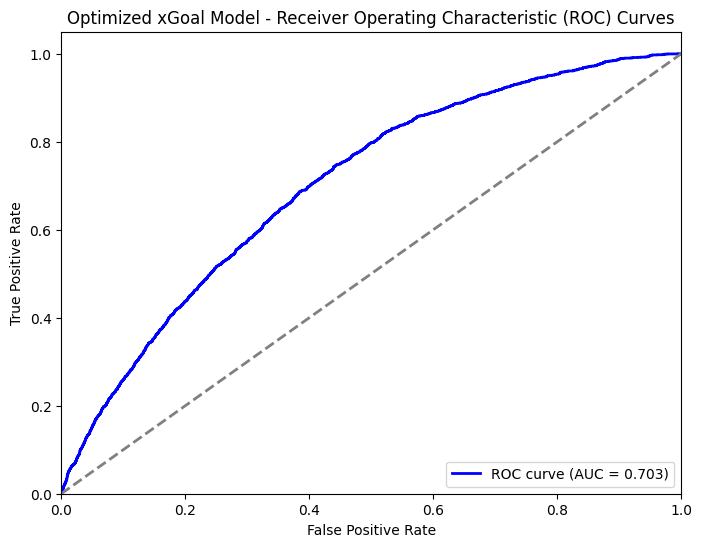

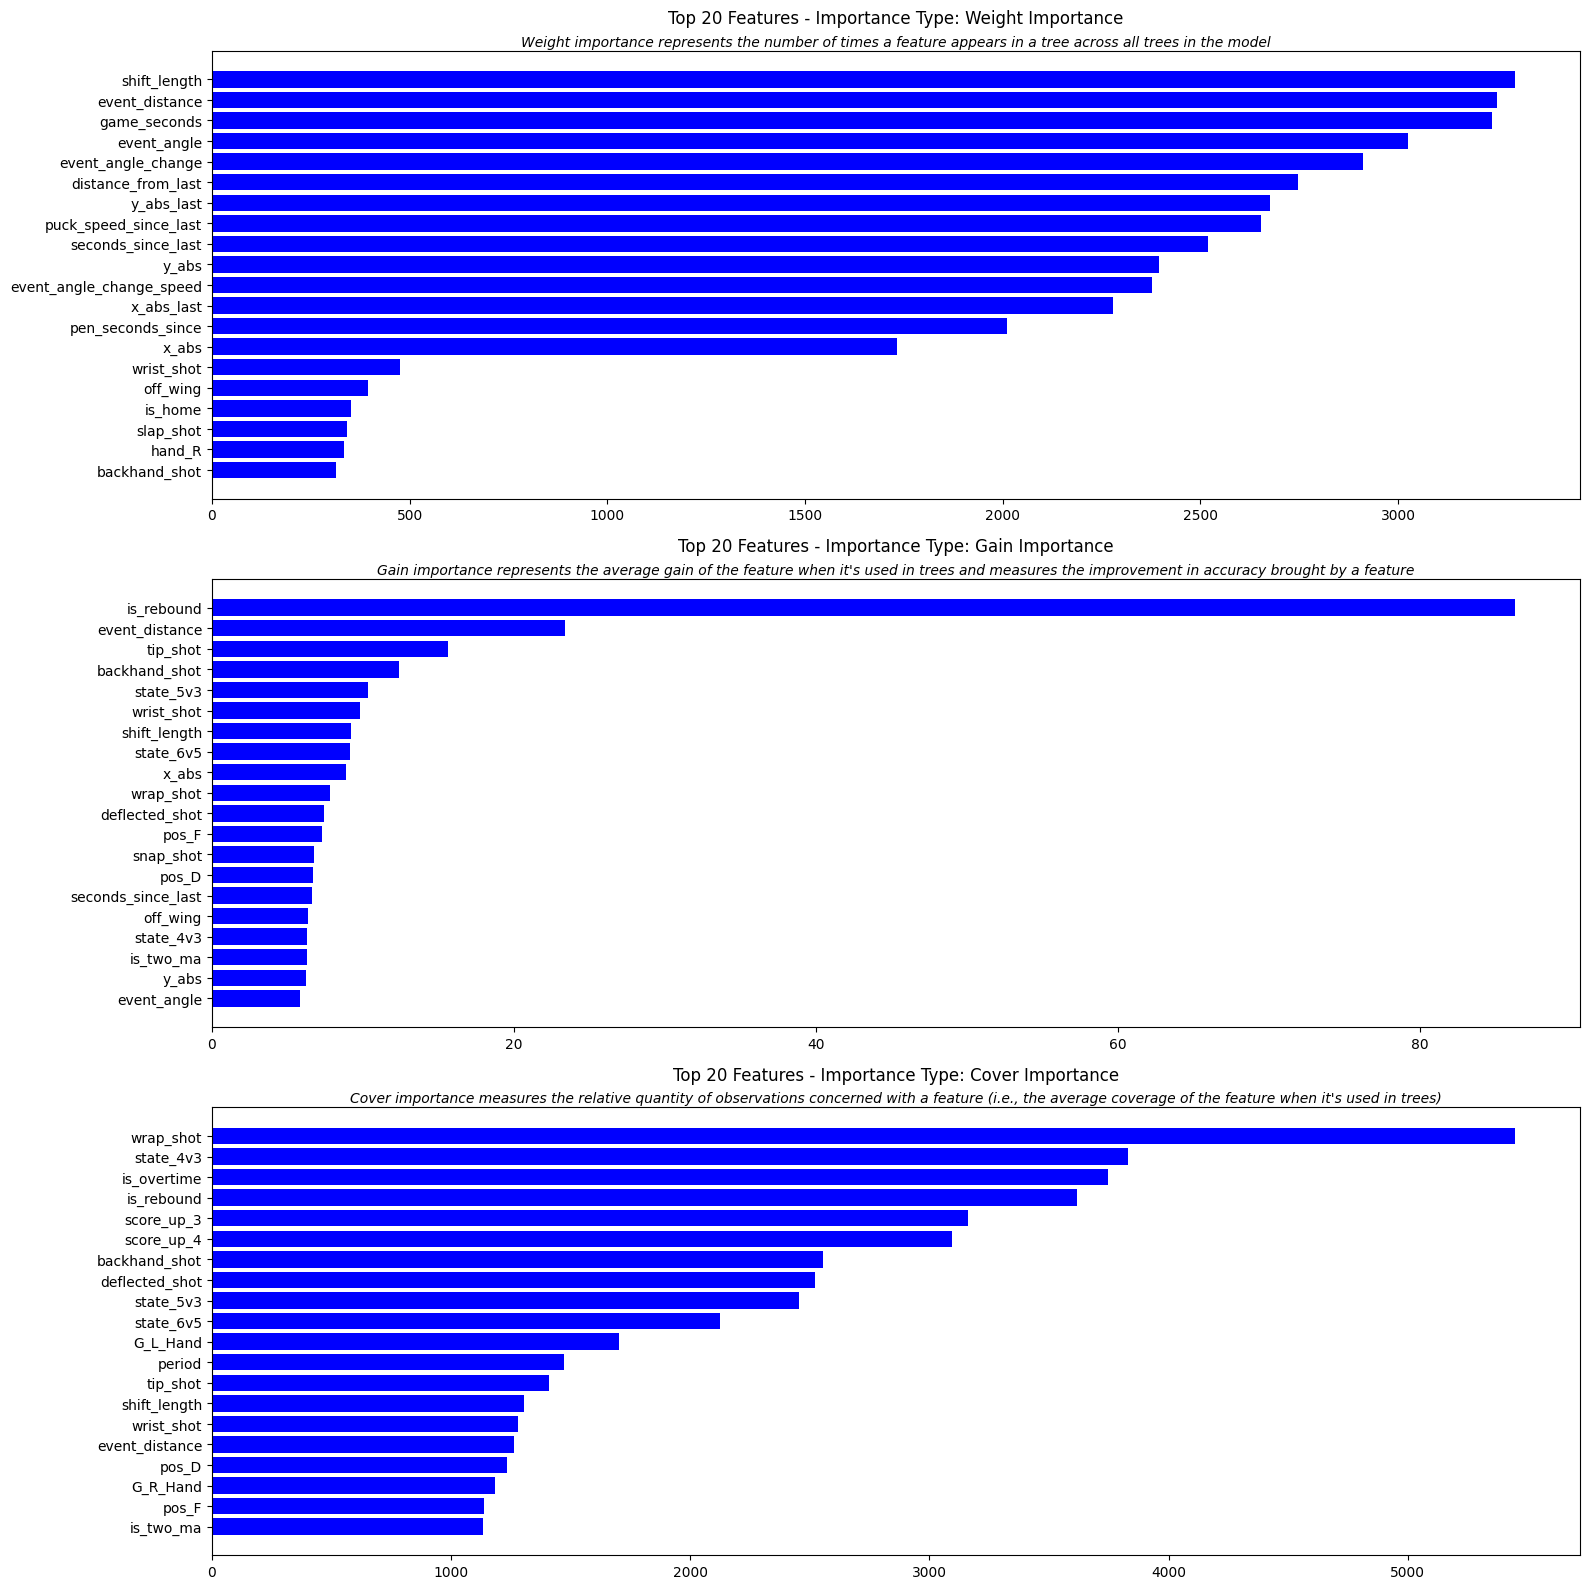

In [244]:
# Train HyperTuned Model
best_pp_model, y_pred_pp, best_pp_logloss, best_pp_auc, best_pp_OT = xgboost_trainer.train_and_evaluate_xgboost(pp_X_train, pp_y_train, pp_X_test, pp_y_test, pp_best_params)

# Return Feature Analysis Plot
Feature_Analysis().plot_top_features(best_pp_model, 20)

## Optimized Short-Handed Model

Optimized xGoal XGBoost Classifier R2 on Test Data: 0.120
Optimized xGoal XGBoost Classifier Log Loss on Test Data: 0.254
Optimized xGoal XGBoost Classifier AUC: 0.821
Optimized xGoal XGBoost Classifier Optimal Treshold: 0.081
Confusion Matrix:
-----------------
[[1630  875]
 [  29  239]]

Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.98      0.65      0.78      2505
           1       0.21      0.89      0.35       268

    accuracy                           0.67      2773
   macro avg       0.60      0.77      0.56      2773
weighted avg       0.91      0.67      0.74      2773



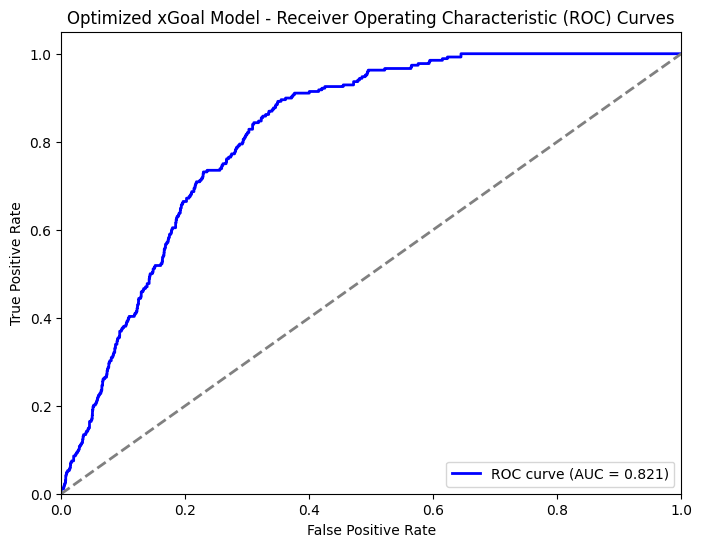

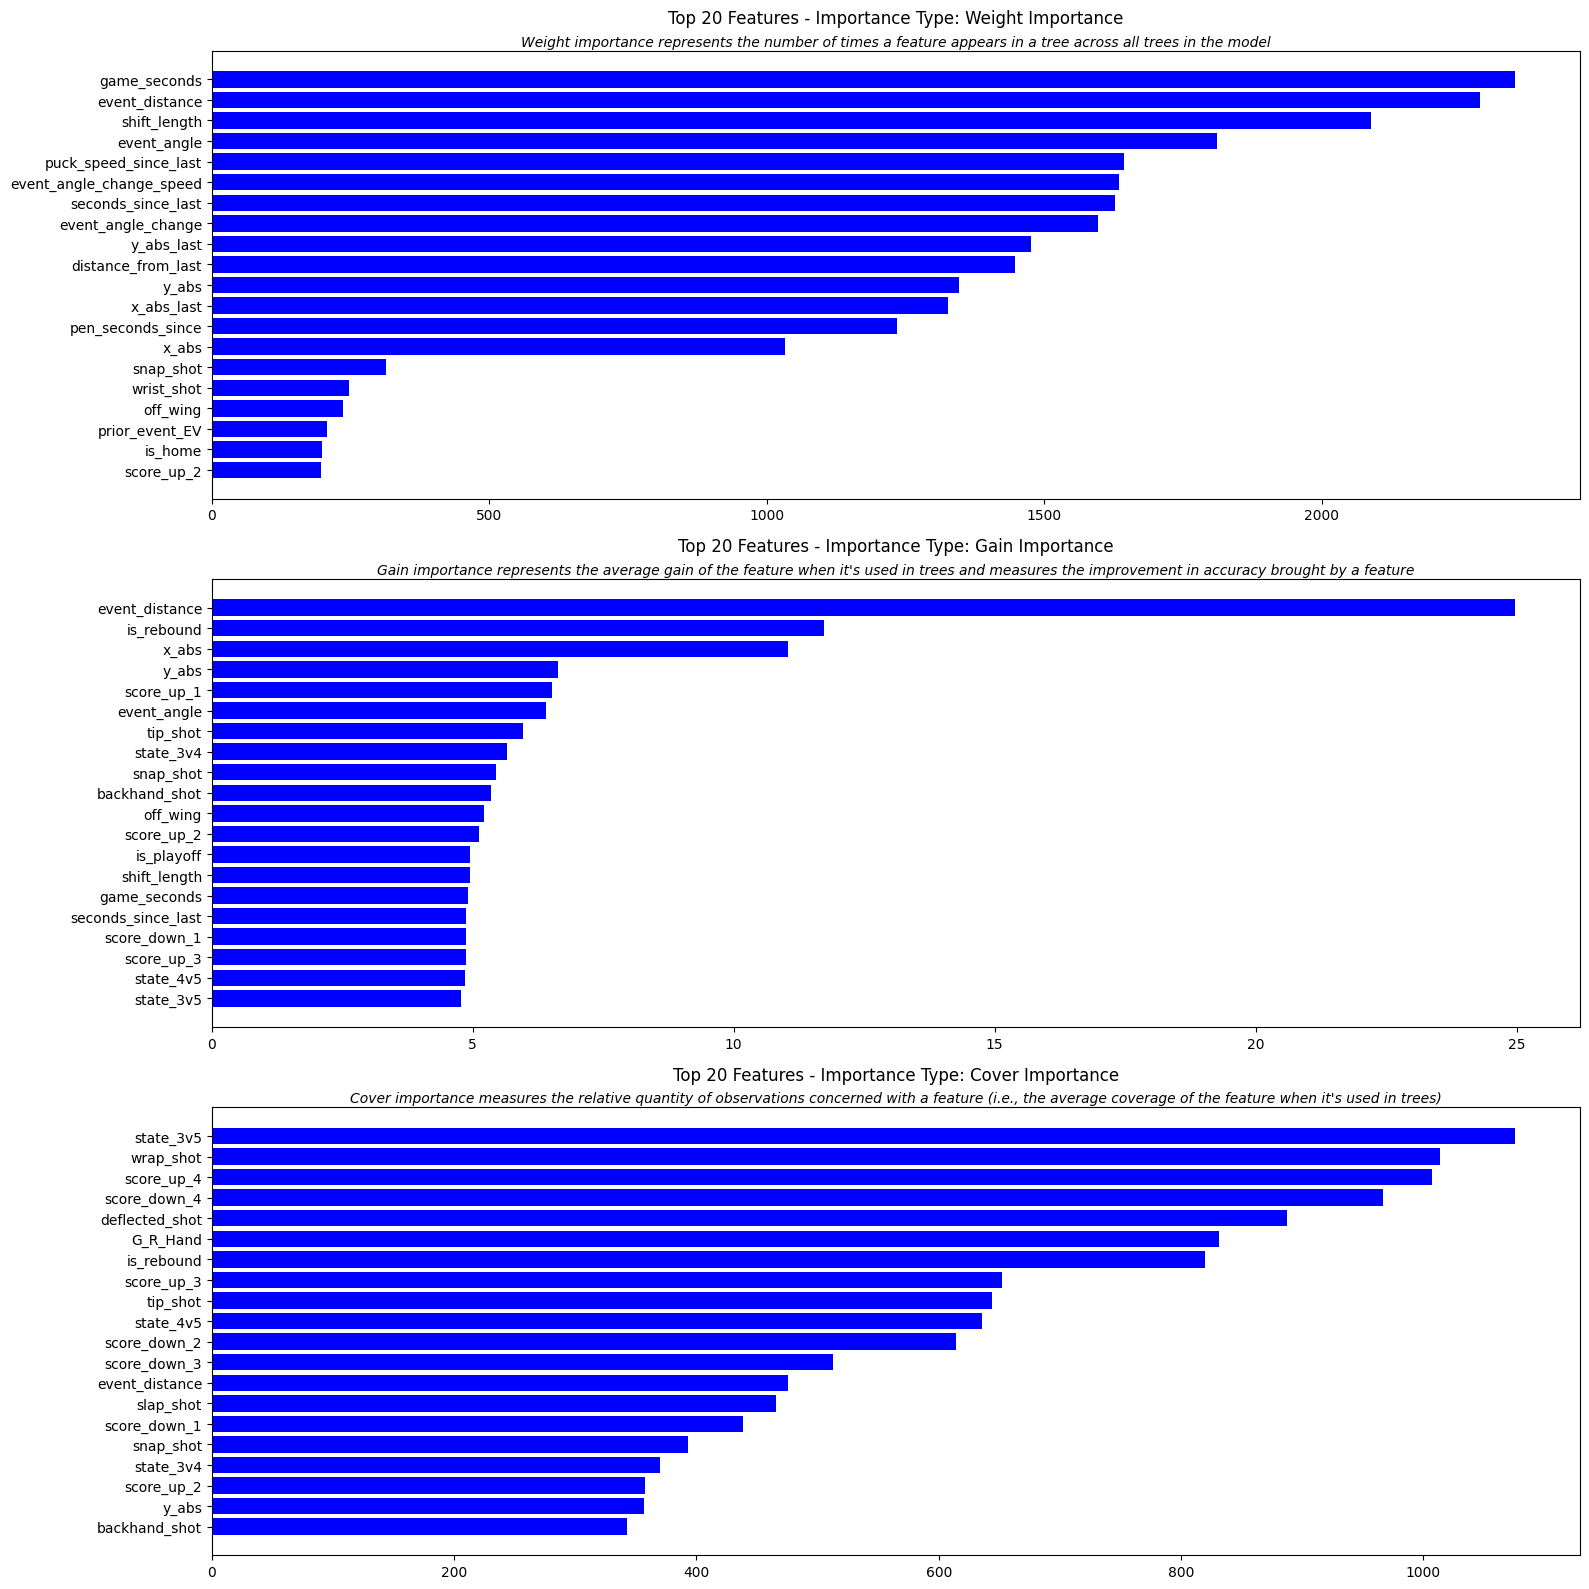

In [245]:
# Train HyperTuned Model
best_sh_model, y_pred_sh, best_sh_logloss, best_sh_auc, best_sh_OT = xgboost_trainer.train_and_evaluate_xgboost(sh_X_train, sh_y_train, sh_X_test, sh_y_test, sh_best_params)

# Return Feature Analysis Plot
Feature_Analysis().plot_top_features(best_sh_model, 20)

## Optimized Empty Net Model

Optimized xGoal XGBoost Classifier R2 on Test Data: 0.860
Optimized xGoal XGBoost Classifier Log Loss on Test Data: 0.129
Optimized xGoal XGBoost Classifier AUC: 0.981
Optimized xGoal XGBoost Classifier Optimal Treshold: 0.624
Confusion Matrix:
-----------------
[[346   0]
 [ 28 475]]

Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       346
           1       1.00      0.94      0.97       503

    accuracy                           0.97       849
   macro avg       0.96      0.97      0.97       849
weighted avg       0.97      0.97      0.97       849



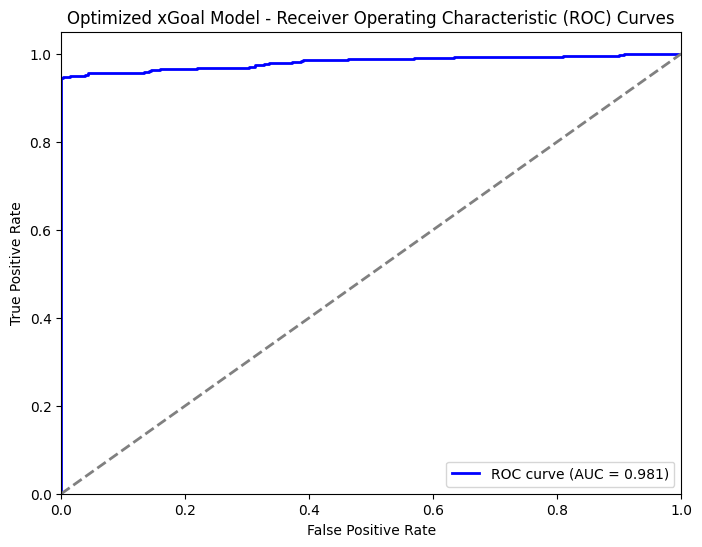

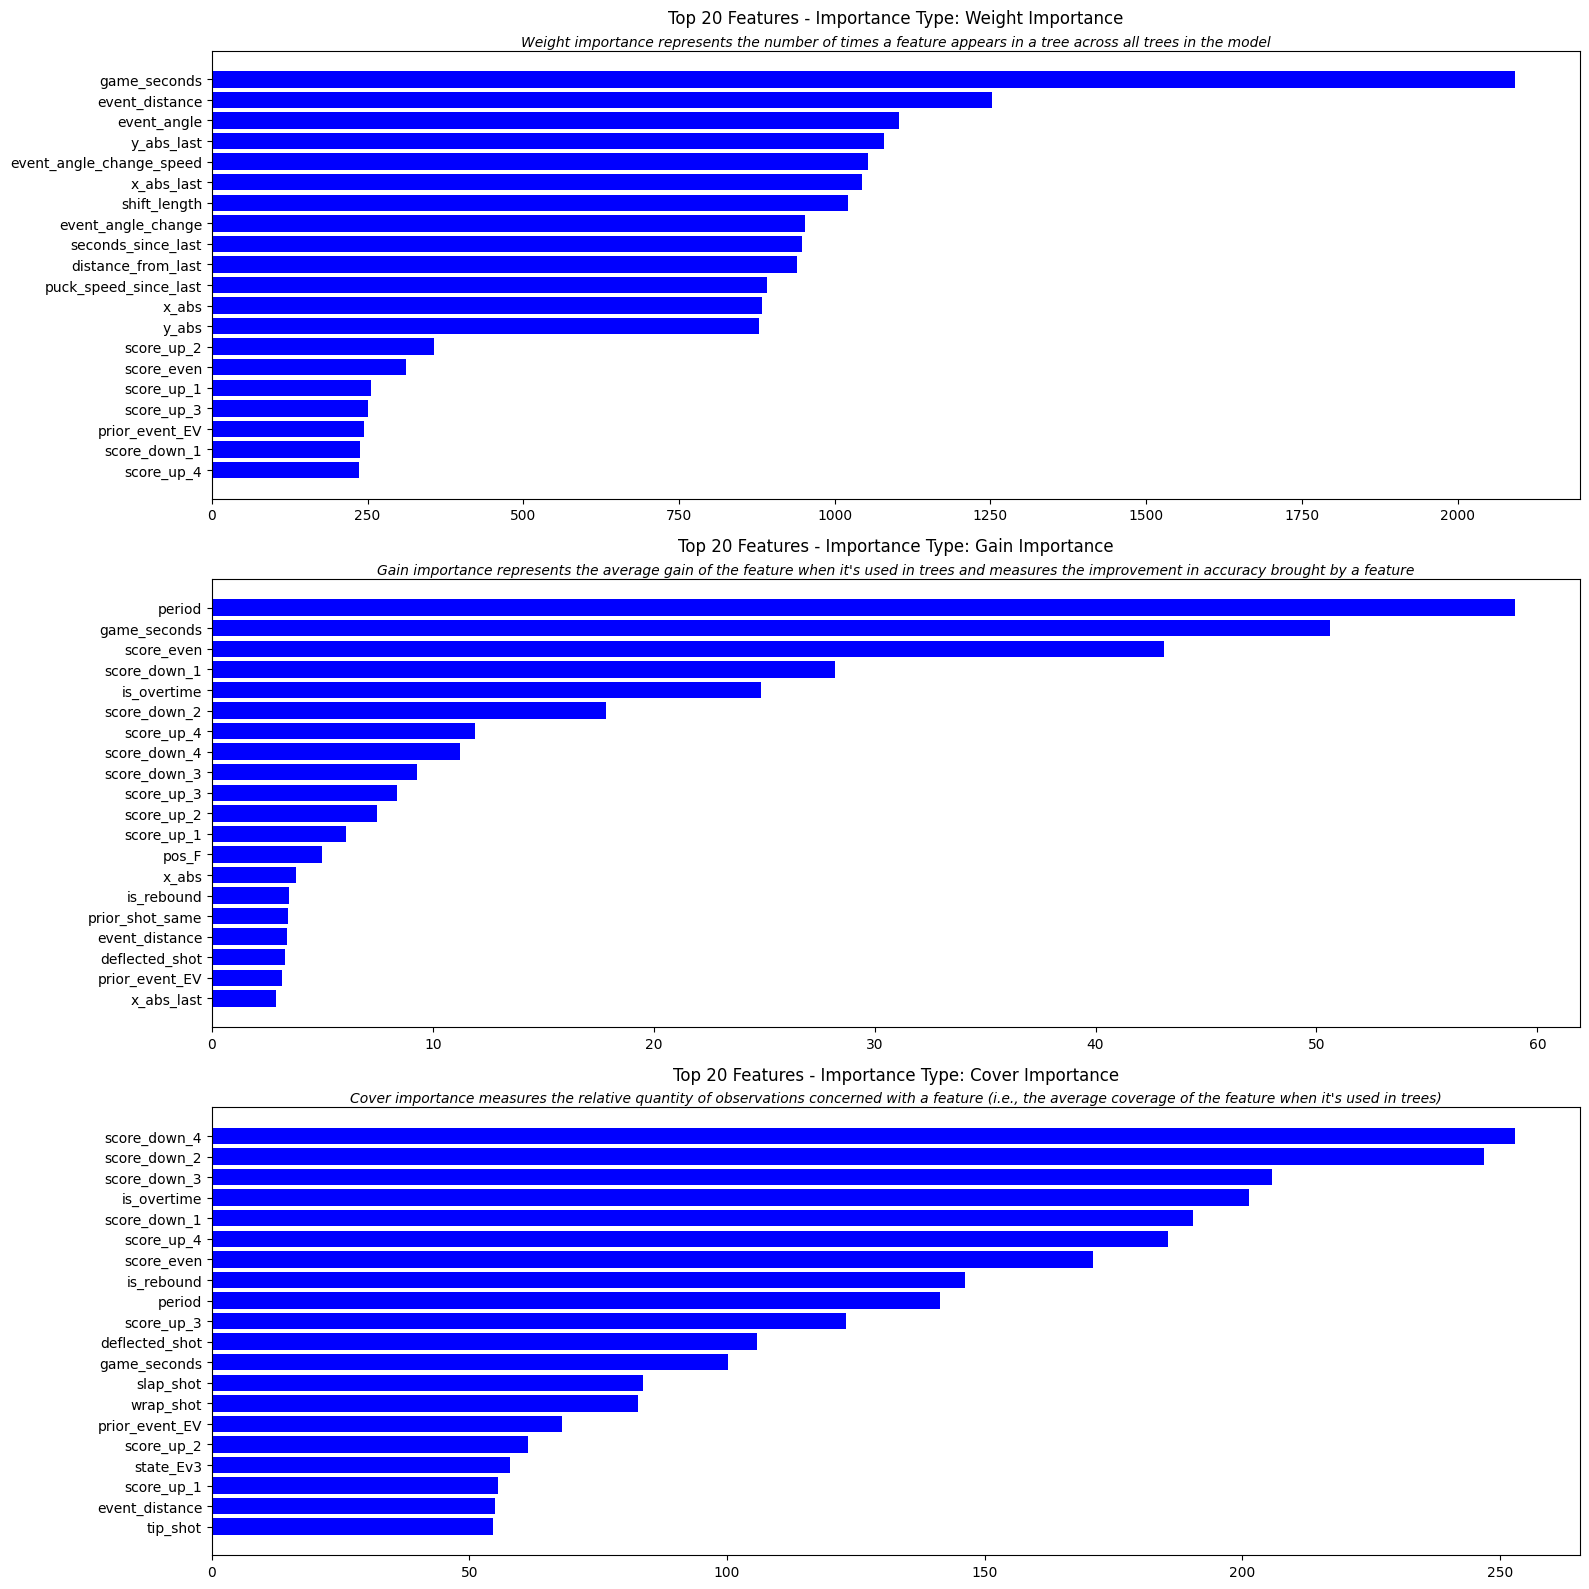

In [246]:
# Train HyperTuned Model
best_en_model, y_pred_en, best_en_logloss, best_en_auc, best_en_OT = xgboost_trainer.train_and_evaluate_xgboost(en_X_train, en_y_train, en_X_test, en_y_test, en_best_params)

# Return Feature Analysis Plot
Feature_Analysis().plot_top_features(best_en_model, 20)

## Analyze Accuracy Metrics

In [247]:
analysis_df = pd.DataFrame({
    'Strength_Type': ['EV', 'EV', 'EV', 'PP', 'PP', 'PP', 'SH', 'SH', 'SH', 'EN', 'EN', 'EN'],
    'Test_Type': ['Sample', 'Current', 'Optimized','Sample', 'Current', 'Optimized','Sample', 'Current', 'Optimized','Sample', 'Current', 'Optimized'],
    'Log_Loss': [ev_logloss_sample, best_ev_logloss, pp_logloss_sample, best_pp_logloss, sh_logloss_sample, best_sh_logloss, en_logloss_sample, best_en_logloss],
    'AUC': [ev_auc_sample, best_ev_auc,  pp_auc_sample, best_pp_auc, sh_auc_sample, best_sh_auc, en_auc_sample, best_en_auc],
    'Optimal_Threshold': [ev_OT_sample, best_ev_OT, pp_OT_sample, best_pp_OT, sh_OT_sample, best_sh_OT, en_OT_sample, best_en_OT],
})

print(analysis_df)

   Strength_Type  Test_Type  Log_Loss       AUC  Optimal_Threshold
0             EV     Sample  0.247457  0.768535           0.068516
1             EV    Current  0.265898  0.750880           0.065323
2             EV  Optimized  0.259585  0.762390           0.083252
3             PP     Sample  0.378885  0.686052           0.099435
4             PP    Current  0.393977  0.663939           0.109799
5             PP  Optimized  0.367122  0.702504           0.118785
6             SH     Sample  0.315758  0.767583           0.015525
7             SH    Current  0.316768  0.796370           0.016839
8             SH  Optimized  0.254084  0.821348           0.081027
9             EN     Sample  0.316768  0.796370           0.016839
10            EN    Current  0.179385  0.978706           0.924344
11            EN  Optimized  0.128540  0.981268           0.624184


# 3) Apply Model

In [249]:
# Filter Test Seasons
EV_DF = EV_PD[EV_PD['season'] > 2022]
PP_DF = PP_PD[PP_PD['season'] > 2022]
SH_DF = SH_PD[SH_PD['season'] > 2022]
EN_DF = EN_PD[EN_PD['season'] > 2022]

## Add xGoals and Model Type
#EV_DF['xG'] = y_pred_ev
#PP_DF['xG'] = y_pred_pp
#SH_DF['xG'] = y_pred_sh
#EN_DF['xG'] = y_pred_en
#
#EV_DF['model_type'] = pd.lit('EV')
#PP_DF['model_type'] = pd.lit('PP')
#SH_DF['model_type'] = pd.lit('SH')
#EN_DF['model_type'] = pd.lit('EN')

# Add xGoals and Model Type using assign
EV_DF = EV_DF.assign(xG=y_pred_ev, model_type='EV')
PP_DF = PP_DF.assign(xG=y_pred_pp, model_type='PP')
SH_DF = SH_DF.assign(xG=y_pred_sh, model_type='SH')
EN_DF = EN_DF.assign(xG=y_pred_en, model_type='EN', reb_angle_change=0.0, reb_angle_change_speed=0.0).astype({'reb_angle_change': 'float64', 'reb_angle_change_speed': 'float64'})

# Select Relevant Features
keep_cols = ['season', 'game_id', 'event_idx', 'model_type', 'xG', 'is_goal',
             'event_distance', 'event_angle', 'x_abs', 'y_abs',
             'is_set_play', 'is_rebound', 'event_angle_change', 'event_angle_change_speed',
             'off_wing', 'hand_R', 'hand_L', 'pos_F', 'pos_D', 'pos_G', 'prior_shot_same',
             'is_rush_play', 'seconds_since_last', 'puck_speed_since_last']
EV_DF = EV_DF[keep_cols]
PP_DF = PP_DF[keep_cols]
SH_DF = SH_DF[keep_cols]
EN_DF = EN_DF[keep_cols]


# To Polars
EV_DF = pl.DataFrame(EV_DF)
PP_DF = pl.DataFrame(PP_DF)
SH_DF = pl.DataFrame(SH_DF)
EN_DF = pl.DataFrame(EN_DF)

# Combine
df_list = [EV_DF, PP_DF, SH_DF, EN_DF]

PRED = df_list[0]
for df in df_list[1:]:
    PRED = PRED.extend(df)
print(str(PRED.height) + " Total Shots in Prediction DF")

PBP = sdv.nhl.load_nhl_pbp(seasons=range(2023,2024)).select(nhl_pbp_cols).extend(sdv.nhl.load_nhl_pbp(seasons=range(2024,2025)).select(nhl_pbp_cols))
print("Max Date:", PBP['game_date'].str.to_date().max())

PBP_xG = PBP.join(PRED, on = ['season','game_id','event_idx'], how= "inner")

91697 Total Shots in Prediction DF


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Max Date: 2023-11-06


## Save Results and Analysis DF

In [250]:
PBP_xG.head()
#PBP_xG['reb_angle_change_speed'].max()

## Network X Package

event_type,event,description,period,period_seconds,period_seconds_remaining,game_seconds,game_seconds_remaining,home_score,away_score,strength_state,event_idx,extra_attacker,home_skaters,away_skaters,game_id,period_type,ordinal_num,period_time,period_time_remaining,date_time,home_final,away_final,season,season_type,game_date,game_start,game_end,game_length,game_state,detailed_state,venue_name,venue_link,home_name,home_abbreviation,home_division_name,home_conference_name,home_id,away_name,away_abbreviation,away_division_name,away_conference_name,away_id,event_id,event_team,event_team_type,num_on,players_on,players_off,away_on_1,away_on_2,away_on_3,away_on_4,away_on_5,away_goalie,ids_on,ids_off,secondary_type,home_on_1,home_on_2,home_on_3,home_on_4,home_on_5,home_goalie,event_player_1_name,event_player_1_type,event_player_2_name,event_player_2_type,strength_code,strength,x,y,x_fixed,y_fixed,event_player_1_id,event_player_1_link,event_player_2_id,event_player_2_link,event_team_id,event_team_link,event_team_abbr,num_off,penalty_severity,penalty_minutes,away_on_6,shot_distance,shot_angle,event_goalie_name,event_goalie_id,event_goalie_link,event_goalie_type,event_player_3_name,event_player_3_type,game_winning_goal,empty_net,event_player_3_id,event_player_3_link,event_player_4_type,event_player_4_id,event_player_4_name,event_player_4_link,home_on_6,venue_id,model_type,xG,is_goal,event_distance,event_angle,x_abs,y_abs,is_set_play,is_rebound,event_angle_change,event_angle_change_speed,off_wing,hand_R,hand_L,pos_F,pos_D,pos_G,prior_shot_same,is_rush_play,seconds_since_last,puck_speed_since_last
str,str,str,i32,i32,i32,i32,i32,i32,i32,str,str,bool,i32,i32,i32,str,str,str,str,str,i32,i32,i32,str,str,str,str,i32,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,i32,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i32,i32,i32,i32,i32,str,i32,str,i32,str,str,i32,str,i32,str,f64,f64,str,i32,str,str,str,str,bool,bool,i32,str,str,i32,str,str,str,i32,str,f32,i32,f64,f64,i32,i32,i32,i32,f64,f64,i32,f64,f64,f64,f64,f64,i32,i32,f64,f64
"""SHOT""","""Shot""","""Mattias Ekholm…",1,59,1141,59,3541,0,0,"""5v5""","""0015""",false,5,5,2022020001,"""REGULAR""","""1st""","""00:59""","""19:01""","""2022-10-07T18:…",4,1,2023,"""R""","""2022-10-07""","""2022-10-07 14:…","""2022-10-07 16:…",33,"""Final""","""Final""","""O2 Czech Repub…","""/api/v1/venues…","""Nashville Pred…","""NSH""","""Central""","""Western""","""18""","""San Jose Shark…","""SJS""","""Pacific""","""Western""","""28""",2.0220e13,"""Nashville Pred…","""home""",null,null,null,"""Logan.Couture""","""Mario.Ferraro""","""Kevin.Labanc""","""Marc.Edouard.V…","""Oskar.Lindblom…","""James.Reimer""",null,null,"""Slap Shot""","""Nino.Niederrei…","""Ryan.McDonagh""","""Kiefer.Sherwoo…","""Mattias.Ekholm…","""Ryan.Johansen""","""Juuse.Saros""","""Mattias.Ekholm…","""Shooter""","""James.Reimer""","""Goalie""","""EV""","""Even""",-33,8,33,-8,8475218,"""/api/v1/people…",8473503,"""/api/v1/people…",18,"""/api/v1/teams/…","""NSH""",null,null,null,null,56.6,8.1,"""James.Reimer""",8473503,"""/api/v1/people…","""Goalie""",null,null,null,null,null,null,null,null,null,null,null,null,"""EV""",0.030127,0,56.568542,8.130102,33,-8,0,0,4.687887,0.130219,0,0.0,1.0,0.0,1.0,0.0,0,0,36.0,2.138889
"""GOAL""","""Goal""","""Kiefer Sherwoo…",1,61,1139,61,3539,1,0,"""5v5""","""0016""",false,5,5,2022020001,"""REGULAR""","""1st""","""01:01""","""18:59""","""2022-10-07T18:…",4,1,2023,"""R""","""2022-10-07""","""2022-10-07 14:…","""2022-10-07 16:…",33,"""Final""","""Final""","""O2 Czech Repub…","""/api/v1/venues…","""Nashville Pred…","""NSH""","""Central""","""Western""","""18""","""San Jose Shark…","""SJS""","""Pacific""","""Western""","""28""",2.0220e13,"""Nashville Pred…","""home""",null,null,null,"""Logan.Couture""","""Mario.Ferraro""","""Kevin.Labanc""","""Marc.Edouard.V…","""Oskar.Lindblom…","""James.Reimer""",null,null,"""Wrist Shot""","""Nino.Niederrei…","""Ryan.M

In [251]:
import pathlib
xG_path = "FinalExpectedGoalsPredictions.parquet"
PBP_xG.write_parquet(
    xG_path,
    use_pyarrow=True,
)

#PBP_xG.write_arrow('FinalExpectedGoalsPredictions.csv')
analysis_df.to_csv('ModelAccuracyScores.csv')

In [252]:
peek_cols = ["game_date", 'period', 'game_seconds',
             'home_abbreviation', 'away_abbreviation','home_score', 'away_score', 'model_type',
             'event_player_1_name', "event_type", "secondary_type", "shot_distance", "shot_angle", 'xG']

PBP_xG.filter((pl.col('event_type') == 'GOAL') & (pl.col('model_type') == 'EV')).sort('xG', descending=False).select(peek_cols).head()

game_date,period,game_seconds,home_abbreviation,away_abbreviation,home_score,away_score,model_type,event_player_1_name,event_type,secondary_type,shot_distance,shot_angle,xG
str,i32,i32,str,str,i32,i32,str,str,str,str,f64,f64,f32
"""2022-12-01""",3,2959,"""PHI""","""TBL""",0,4,"""EV""","""Ian.Cole""","""GOAL""","""Wrist Shot""",99.4,20.6,0.003874
"""2023-03-21""",2,2218,"""MTL""","""TBL""",3,1,"""EV""","""Mike.Matheson""","""GOAL""","""Wrist Shot""",64.8,26.6,0.00432
"""2022-12-22""",1,421,"""VAN""","""SEA""",0,1,"""EV""","""Jared.McCann""","""GOAL""","""Snap Shot""",75.8,31.0,0.004576
"""2022-11-03""",1,252,"""OTT""","""VGK""",1,1,"""EV""","""Claude.Giroux""","""GOAL""","""Wrist Shot""",83.5,16.7,0.004647
"""2023-01-19""",3,3337,"""NYR""","""BOS""",1,3,"""EV""","""Ben.Harpur""","""GOAL""","""Wrist Shot""",57.5,40.1,0.004922


## League Standings - Goal Differences

In [253]:
# Pull Schedule

#PBP_xG.agg((pl.col('game_date').str.to_date().max()).alias('max_game_date'))
print(PBP_xG['game_date'].str.to_date().max())

2023-11-06


In [254]:
bet_teams = ['TOR', 'DET']
pythag_exp = 1.86

Def = (
    PBP_xG
    .with_columns((pl.when(pl.col('event_team_abbr') == pl.col('home_abbreviation'))
                     .then(pl.col('away_abbreviation'))
                     .otherwise(pl.col('home_abbreviation'))).alias('team'))
     .filter(((pl.col('season')==2024)) & (pl.col('season_type') == 'R') & (pl.col('model_type') != 'EN'))
     .groupby('team')
     .agg([
         (pl.col('xG').sum()).alias('xGoals_Against'),
         ((pl.when(pl.col('event_type') == 'GOAL')
             .then(pl.lit(1)).otherwise(pl.lit(0))).sum())
             .alias('Goals_Against')
          ])
     .with_columns((pl.col('Goals_Against') - pl.col('xGoals_Against')).alias('D_Diff_Over_Under'))
     .sort('xGoals_Against', descending = True)
)

Off = (
    PBP_xG
    .with_columns(pl.col('event_team_abbr').alias('team'))
    .filter(((pl.col('season')==2024)) & (pl.col('season_type') == 'R') & (pl.col('model_type') != 'EN'))
    .groupby('team')
    .agg([(pl.col('xG').sum()).alias('xGoals_For'),
          ((pl.when(pl.col('event_type') == 'GOAL')
              .then(pl.lit(1))
              .otherwise(pl.lit(0))).sum()).alias('Goals_For')
          ])
     .with_columns((pl.col('Goals_For') - pl.col('xGoals_For')).alias('O_Diff_Over_Under'))
     .sort('xGoals_For', descending = True)
)

NHL_Stats = (
    Off
    .join(Def, on = 'team', how = "inner")
    .with_columns([
    (pl.col('xGoals_For') - pl.col('xGoals_Against')).alias('xG_Difference'),
    (pl.col('Goals_For') - pl.col('Goals_Against')).alias('G_Difference')
     ])
     .with_columns(
         (pl.col('G_Difference') - (pl.col('xG_Difference') )).alias('Diff_Over_Under'),
         ((pl.col('xGoals_For').pow(pythag_exp)) / ((pl.col('xGoals_For').pow(pythag_exp)) + (pl.col('xGoals_Against').pow(pythag_exp)))).alias('xGWin_Pct'),
         ((pl.col('Goals_For').pow(pythag_exp)) / ((pl.col('Goals_For').pow(pythag_exp)) + (pl.col('Goals_Against').pow(pythag_exp)))).alias('GWin_Pct')
         )
     .sort('xGWin_Pct', descending=True)
)

NHL_Stats.head(32) #.filter(pl.col('team').is_in(bet_teams))

team,xGoals_For,Goals_For,O_Diff_Over_Under,xGoals_Against,Goals_Against,D_Diff_Over_Under,xG_Difference,G_Difference,Diff_Over_Under,xGWin_Pct,GWin_Pct
str,f32,i32,f64,f32,i32,f64,f32,i32,f64,f32,f64
"""PIT""",36.613831,32,-4.613831,23.888393,29,5.111607,12.725437,3,-9.725437,0.68875,0.545647
"""PHI""",32.80542,32,-0.80542,23.485718,35,11.514282,9.319702,-3,-12.319702,0.650586,0.458427
"""NSH""",33.416592,29,-4.416592,24.975941,26,1.024059,8.440651,3,-5.440651,0.632166,0.550604
"""LAK""",31.886658,42,10.113342,26.982349,29,2.017651,4.904308,13,8.095692,0.577039,0.665721
"""ARI""",32.98782,34,1.01218,28.347115,30,1.652885,4.640705,4,-0.640705,0.570037,0.557939
"""WPG""",32.87141,32,-0.87141,28.465065,33,4.534935,4.406345,-1,-5.406345,0.566529,0.485695
"""NJD""",32.562244,40,7.437756,28.312874,33,4.687126,4.249371,7,2.750629,0.56466,0.588511
"""FLA""",28.755756,26,-2.755756,25.248314,30,4.751686,3.507442,-4,-7.507442,0.560193,0.433848
"""TOR""",37.490116,39,1.509884,33.328808,35,1.671192,4.161308,4,-0.161308,0.554492,0.55015


In [997]:
import requests
# Variables
date_str = "2023-11-17"

# Create Predictions
sched_link = "https://api-web.nhle.com/v1/schedule/"+date_str
response = requests.get(sched_link)

# Parse the JSON content of the response
raw_data = pd.json_normalize(response.json())
sched_data = pd.json_normalize(raw_data['gameWeek'][0])

# Get Odds
odds_data = pd.json_normalize(raw_data['oddsPartners'][0])
US_Prov_ID = int(odds_data[odds_data['country'] == 'US']['partnerId'].iloc[0])
sched_data = pd.json_normalize(sched_data['games'][0])
game_df = sched_data[['id', 'season', 'gameState', 'awayTeam.abbrev', 'homeTeam.abbrev', 'homeTeam.odds', 'awayTeam.odds', 'gameCenterLink']]

In [1030]:
game_dfs = []
idx = 0

## Existing Game Odds
exist_id = [2023020251]
exist_home_odds = [ 165]
exist_away_odds = [-180]

exist_df = pd.DataFrame({
    'id': exist_id,
    'home_odds': exist_home_odds,
    'away_odds': exist_away_odds
})


for i in game_df['id']:

    raw_df = game_df[game_df['id'] == i]

    try:
        # Load Game Data
        home_odds_df = pd.json_normalize(raw_df['homeTeam.odds'][idx])
        away_odds_df = pd.json_normalize(raw_df['awayTeam.odds'][idx])

        home_odd = home_odds_df[home_odds_df['providerId'] == US_Prov_ID]['value'].iloc[0]
        away_odd = away_odds_df[away_odds_df['providerId'] == US_Prov_ID]['value'].iloc[0]

        df = raw_df[['id', 'season', 'awayTeam.abbrev', 'homeTeam.abbrev', 'gameState']]
        df = df.assign(home_odds=home_odd, away_odds=away_odd, game_date=date_str)

        game_dfs.append(df)

    except Exception as e:

        # Load Game Data
        df = raw_df[raw_df['id'] == i]

        home_odd = exist_df[exist_df['id'] == i]['home_odds'].iloc[0]
        away_odd = exist_df[exist_df['id'] == i]['away_odds'].iloc[0]

        df = raw_df[['id', 'season', 'awayTeam.abbrev', 'homeTeam.abbrev','gameState']]
        df = df.assign(home_odds=home_odd, away_odds=away_odd, game_date=date_str).astype({'home_odds': 'float64', 'away_odds': 'float64'})

        gme_lab = str(df['awayTeam.abbrev'].iloc[0])+ ' ('+ str(round(away_odd, 0)) + ') @ '+str(df['homeTeam.abbrev'].iloc[0]+ ' ('+ str(round(home_odd, 0)) + ')')

        print(f"{gme_lab} Has Already Started")

        game_dfs.append(df)

    # Move To Next Game
    idx += 1

# Concatenate all DataFrames in the game_dfs list into a single polarsDataFrame
result_df = pd.concat(game_dfs, ignore_index=True).astype({'home_odds': 'float64', 'away_odds': 'float64'})
result_df = pl.DataFrame(result_df)

TOR (-180) @ DET (165) Has Already Started


In [1042]:
Bet_DF = (
    result_df
    .join(NHL_Stats.select([(pl.col(col).alias(f'away_{col}')) for col in NHL_Stats.columns]), left_on=['awayTeam.abbrev'], right_on=['away_team'])
    .join(NHL_Stats.select([(pl.col(col).alias(f'home_{col}')) for col in NHL_Stats.columns]), left_on=['homeTeam.abbrev'], right_on=['home_team'])
    .with_columns([
        ((pl.col('home_xGWin_Pct')) * (1 - pl.col('away_xGWin_Pct'))).alias('home_win'),
        ((pl.col('away_xGWin_Pct')) * (1 - pl.col('home_xGWin_Pct'))).alias('away_win'),
        (pl.when(pl.col('home_odds') < 0).then((-1*(pl.col('home_odds'))) / ((-1*(pl.col('home_odds')) + 100))).otherwise(100 / (pl.col('home_odds') + 100))).alias('home_imp_prob'),
        (pl.when(pl.col('away_odds') < 0).then((-1*(pl.col('away_odds'))) / ((-1*(pl.col('away_odds')) + 100))).otherwise(100 / (pl.col('away_odds') + 100))).alias('away_imp_prob')
    ])
    .with_columns([
        ((pl.col('home_win')) / (pl.col('home_win') + pl.col('away_win'))).alias('home_win'),
        ((pl.col('away_win')) / (pl.col('home_win') + pl.col('away_win'))).alias('away_win')
        
    ])
    .with_columns([
        (pl.col('home_win') - pl.col('home_imp_prob')).alias('home_xAdvantage'),
        (pl.col('away_win') - pl.col('away_imp_prob')).alias('away_xAdvantage')
    ])
    .with_columns([
        (pl.when(pl.col('home_xAdvantage') > pl.col('away_xAdvantage')).then(pl.col('home_xAdvantage')).otherwise(pl.col('away_xAdvantage'))).alias('Advantage'),
        (pl.when(pl.col('home_xAdvantage') > pl.col('away_xAdvantage')).then(pl.col('homeTeam.abbrev')).otherwise(pl.col('awayTeam.abbrev'))).alias('Bet_Team')
    ])
    .rename({"awayTeam.abbrev":"away_team", "homeTeam.abbrev":"home_team"})
    .select('id', "game_date", 'away_team', 'away_odds', 'away_imp_prob', 'away_win', 'home_team','home_odds', 'home_imp_prob', 'home_win', 'Bet_Team', 'Advantage')
)

Pretty_Bet_DF = (
    Bet_DF
    .select([
        pl.col("game_date").alias('Date'),
        pl.col("id").alias("Game ID"),
        pl.col("away_team").alias('Away Team'),
        pl.col('away_odds').round(0).alias('Away Odds'),
        pl.format("{}%", (pl.col('away_imp_prob')*100).round(2)).alias('Away ImpProb'),
        pl.format("{}%", (pl.col('away_win')*100).round(2)).alias('Away ExpWin'),
        pl.col("home_team").alias('Home Team'),
        pl.col('home_odds').round(0).alias('Home Odds'),
        pl.format("{}%", (pl.col('home_imp_prob')*100).round(2)).alias('Home ImpProb'),
        pl.format("{}%", (pl.col('home_win')*100).round(2)).alias('Home ExpWin'),
        pl.col("Bet_Team").alias("Bet Team"),
        pl.col("Advantage").alias('AdvNum'),
    ])
    .with_columns(pl.format("{}%", (pl.col('AdvNum')*100).round(2)).alias('Advantage'))
    .sort("AdvNum", descending=True)
    .drop('AdvNum')
)


with pl.Config(tbl_formatting="ASCII_FULL", tbl_hide_column_data_types=True, tbl_hide_dataframe_shape=True) as cfg:
    cfg.set_tbl_width_chars(200)
    print(Pretty_Bet_DF)

+------------+------------+-----------+-----------+--------------+-------------+-----------+-----------+--------------+-------------+----------+-----------+
| Date       | Game ID    | Away Team | Away Odds | Away ImpProb | Away ExpWin | Home Team | Home Odds | Home ImpProb | Home ExpWin | Bet Team | Advantage |
+==========================================================================================================================================================+
| 2023-11-17 | 2023020251 | TOR       | -180.0    | 64.29%       | 52.63%      | DET       | 165.0     | 37.74%       | 47.37%      | DET      | 9.63%     |
|------------+------------+-----------+-----------+--------------+-------------+-----------+-----------+--------------+-------------+----------+-----------|
| 2023-11-17 | 2023020252 | BUF       | 150.0     | 40.0%        | 31.37%      | WPG       | -180.0    | 64.29%       | 68.63%      | WPG      | 4.35%     |
|------------+------------+-----------+-----------+-------

In [743]:
from matplotlib.colors import LinearSegmentedColormap
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.colormaps.register(cmap=newcmap)

    return newcmap



In [ ]:
EV_PBP.filter(pl.col('shot_distance') != pl.col('event_distance'))

100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


[2]
X Min and Max:  -100 100
Y Min and Max:  -42.5 42.5


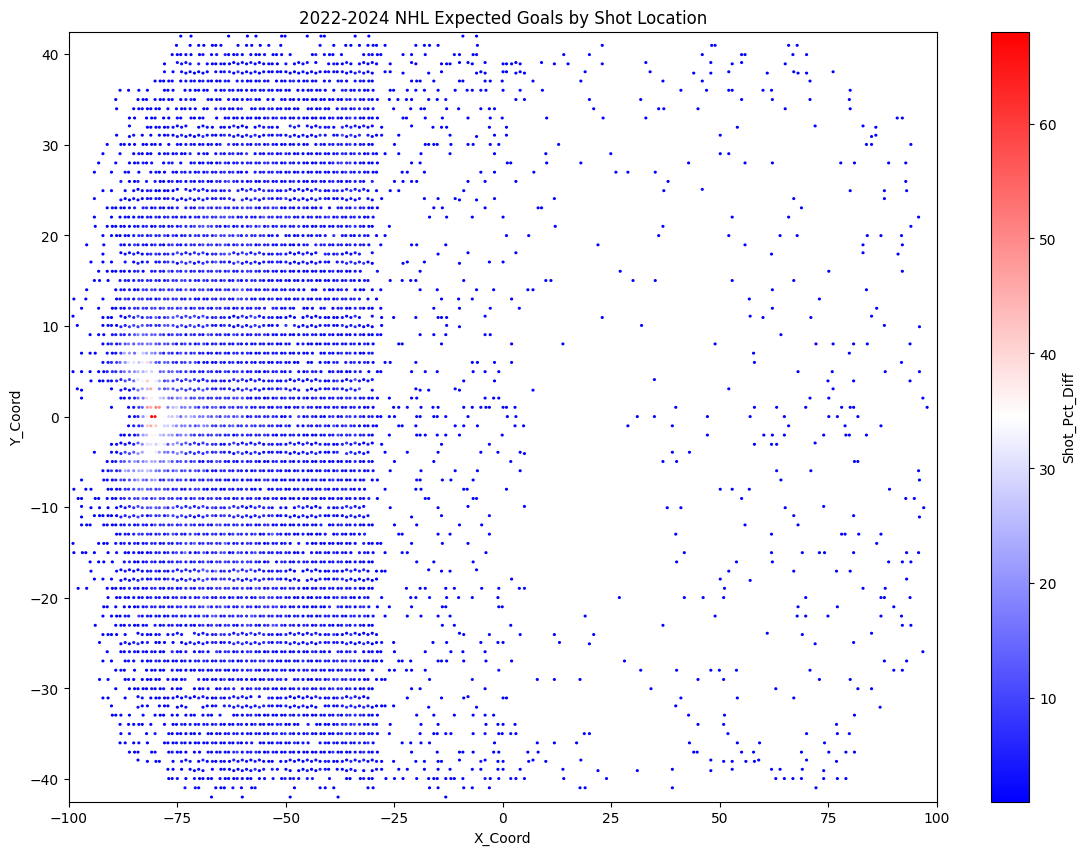

In [132]:
#tgt_player = 'Sidney.Crosby'
#
#plot_data = (
#    PBP_xG.filter((pl.col('x_fixed') > 26) & (pl.col('model_type') == 'EV'))
#    .with_columns(pl.when(pl.col("event_player_1_name") == tgt_player).then(pl.lit(tgt_player.replace(".", " "))).otherwise(pl.lit("NHL Average")).alias('Grouping'))
#    .with_columns([
#        pl.when(pl.col('event_type') == 'GOAL').then(pl.lit(1)).otherwise(pl.lit(0)).alias('Goals'),
#        pl.when(pl.col('event_type').is_in(['SHOT', "MISSED_SHOT"])).then(pl.lit(1)).otherwise(pl.lit(0)).alias('Shots')
#    ])
#    .groupby("x_fixed", "y_fixed")
#    .agg([
#        (pl.col('xG').sum()).alias("NHL_xG_Pct"),
#        (((pl.col('Goals') == 1).sum()) ).alias("Ply_Shot_Pct")
#    ])
#    .with_columns([
#        ((pl.col("NHL_xG_Pct")) - (pl.col("Ply_Shot_Pct"))).alias("Shot_Pct_Diff")
#    ])
#    .select(["x_fixed", "y_fixed", "Shot_Pct_Diff"])
#    .to_pandas()
#)

plot_data = sdv.nhl.load_nhl_pbp(seasons=range(2023,2024)).select(nhl_pbp_cols).extend(sdv.nhl.load_nhl_pbp(seasons=range(2024,2025)).select(nhl_pbp_cols))

plot_data = (
    plot_data
    .filter((pl.col('event_type').is_in(fenwick_events)))
    .filter(~((pl.col('x_fixed').is_null()) & (pl.col('y_fixed').is_null())))
    .filter((pl.col('event_team_type') == 'away') & (pl.col('period') == 2))
    .with_columns((pl.lit(1)).alias('is_shot'))
    .groupby("x_fixed", "y_fixed", 'period')
    .agg(pl.col('is_shot').sum().alias('shots'))
    .select('x_fixed', 'y_fixed', 'shots', 'period')
    .to_pandas()
)

print(plot_data.period.unique())

#plot_data = (
#    EV_PBP
#    .select('x_fixed', 'y_fixed', 'is_goal')
#    .groupby("x_fixed", "y_fixed")
#    .agg(pl.col('is_goal').count().alias('shots'))
#    .to_pandas()
#)


plot_data.dropna(inplace = True)
plot_data.head()

rink = NHLRink(rotation=270, net={"visible": False})

## Define the axis limits
x_min, x_max = -100, 100
y_min, y_max = -42.5, 42.5

#shrunk_cmap = shiftedColorMap(matplotlib.cm.RdYlGn, start=plot_data['Shot_Pct_Diff'].min(), midpoint=0, stop=plot_data['Shot_Pct_Diff'].max(), name = 'NHL Total2')


# Create a custom colormap
colors = [(1, 0, 0), (1, 1, 1), (0, 1, 0)]  # Red to white to green
n_bins = 256
cmap_name = "custom"
#cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Modify the colormap to make 0 white
#cmap(np.linspace(0, 1, n_bins))
#cmap.set_bad('white')



## Create a heatmap
plt.figure(figsize=(14, 10))

hb = plt.hexbin(plot_data['x_fixed'], plot_data['y_fixed'], C=plot_data['shots'], gridsize=500, cmap="bwr", extent=(plot_data['x_fixed'].min(), plot_data['x_fixed'].max(), plot_data['y_fixed'].min(), plot_data['y_fixed'].max()))
cbar = plt.colorbar(hb)
cbar.set_label('Shot_Pct_Diff')

# Set the axis limits
plt.xlim(x_min, x_max)
print("X Min and Max: ", x_min, x_max)
plt.ylim(y_min, y_max)
print("Y Min and Max: ", y_min, y_max)

# Add labels and title
plt.xlabel('X_Coord')
plt.ylabel('Y_Coord')
plt.title('2022-2024 NHL Expected Goals by Shot Location')

# Show the plot
plt.show()

In [741]:
del shrunk_cmap

The following kwargs were not used by contour: 'statistic'


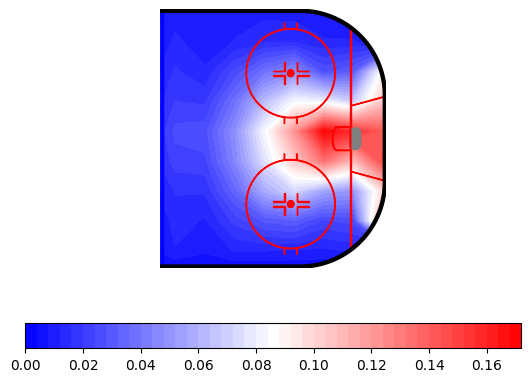

In [823]:
from hockey_rink import NHLRink

# Set Up Data
plot_data = (
    PBP_xG
    .filter(
        (pl.col('model_type') == 'EV')
    )
).to_pandas()

fig = plt.plot(figsize=(28,16))
rink = NHLRink(rotation=0)
rink.draw(display_range="ozone")

contour_img = rink.contourf(plot_data.x_abs, plot_data.y_abs, values=plot_data.xG, cmap="bwr", 
                            plot_range="ozone", binsize=10, levels=50, statistic="mean")
plt.colorbar(contour_img, orientation="horizontal")

In [809]:
PBP_xG.filter(
        (pl.col('model_type') == 'EV') &
        (pl.col('event_team_abbr') == 'PIT') &
        (pl.col('x_abs') > 89) &
        (pl.col('is_goal') == 1)
    ).head()

event_type,event,description,period,period_seconds,period_seconds_remaining,game_seconds,game_seconds_remaining,home_score,away_score,strength_state,event_idx,extra_attacker,home_skaters,away_skaters,game_id,period_type,ordinal_num,period_time,period_time_remaining,date_time,home_final,away_final,season,season_type,game_date,game_start,game_end,game_length,game_state,detailed_state,venue_name,venue_link,home_name,home_abbreviation,home_division_name,home_conference_name,home_id,away_name,away_abbreviation,away_division_name,away_conference_name,away_id,event_id,event_team,event_team_type,num_on,players_on,players_off,away_on_1,away_on_2,away_on_3,away_on_4,away_on_5,away_goalie,ids_on,ids_off,secondary_type,home_on_1,home_on_2,home_on_3,home_on_4,home_on_5,home_goalie,event_player_1_name,event_player_1_type,event_player_2_name,event_player_2_type,strength_code,strength,x,y,x_fixed,y_fixed,event_player_1_id,event_player_1_link,event_player_2_id,event_player_2_link,event_team_id,event_team_link,event_team_abbr,num_off,penalty_severity,penalty_minutes,away_on_6,shot_distance,shot_angle,event_goalie_name,event_goalie_id,event_goalie_link,event_goalie_type,event_player_3_name,event_player_3_type,game_winning_goal,empty_net,event_player_3_id,event_player_3_link,event_player_4_type,event_player_4_id,event_player_4_name,event_player_4_link,home_on_6,venue_id,model_type,xG,is_goal,event_distance,shot_angle_right,x_abs,y_abs,is_set_play,is_rebound,reb_angle_change,reb_angle_change_speed,off_wing,hand_R,hand_L,pos_F,pos_D,pos_G,prior_shot_same,is_rush_play,seconds_since_last,puck_speed_since_last
str,str,str,i32,i32,i32,i32,i32,i32,i32,str,str,bool,i32,i32,i32,str,str,str,str,str,i32,i32,i32,str,str,str,str,i32,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,i32,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i32,i32,i32,i32,i32,str,i32,str,i32,str,str,i32,str,i32,str,f64,f64,str,i32,str,str,str,str,bool,bool,i32,str,str,i32,str,str,str,i32,str,f32,i32,f64,f64,i32,i32,i32,i32,f64,f64,i32,f64,f64,f64,f64,f64,i32,i32,i32,f64
"""GOAL""","""Goal""","""Bryan Rust (3)…",2,120,1080,1320,2280,1,3,"""5v5""","""0313""",false,5,5,2022020094,"""REGULAR""","""2nd""","""02:00""","""18:00""","""2022-10-25T01:…",6,3,2023,"""R""","""2022-10-24""","""2022-10-24 20:…","""2022-10-24 22:…",14,"""Final""","""Final""","""Rogers Place""","""/api/v1/venues…","""Edmonton Oiler…","""EDM""","""Pacific""","""Western""","""22""","""Pittsburgh Pen…","""PIT""","""Metropolitan""","""Eastern""","""5""",2.0220e13,"""Pittsburgh Pen…","""away""",null,null,null,"""Jan.Rutta""","""Bryan.Rust""","""Evgeni.Malkin""","""Jason.Zucker""","""Pierre.Olivier…","""Tristan.Jarry""",null,null,"""Backhand""","""Warren.Foegele…","""Ryan.Murray""","""Ryan.McLeod""","""Evan.Bouchard""","""Jesse.Puljujar…","""Jack.Campbell""","""Bryan.Rust""","""Scorer""","""Evgeni.Malkin""","""Assist""","""EV""","""Even""",91,10,-91,-10,8475810,"""/api/v1/people…",8471215,"""/api/v1/people…",5,"""/api/v1/teams/…","""PIT""",null,null,null,null,10.2,101.3,"""Jack.Campbell""",8475789,"""/api/v1/people…","""Goalie""","""Jason.Zucker""","""Assist""",false,false,8475722,"""/api/v1/people…","""Goalie""",8475789,"""Jack Campbell""","""/api/v1/people…",null,5100,"""EV""",0.115732,1,10.198039,101.3,91,10,0,0,0.0,0.0,1,1.0,0.0,1.0,0.0,0.0,0,0,0,37.20215
"""GOAL""","""Goal""","""Bryan Rust (2)…",3,18,1182,2418,1182,1,1,"""5v5""","""0521""",false,5,5,2023020025,"""REGULAR""","""3rd""","""00:18""","""19:42""","""2023-10-15T01:…",5,2,2024,"""R""","""2023-10-14""","""2023-10-14 19:…","""2023-10-14 21:…",23,"""Final""","""Final""","""PPG Paints Are…","""/api/v1/venues…","""Pittsburgh Pen…","""PIT""","""Metropolitan""","""Eastern""","""5""","""Calgary Flames…","""CGY""","""Pacific""","""Western""","""20""",2.0230e13,"""Pittsburgh Pen…","""home""",null,null,null,"""Jonathan.Huber…","""Rasmus.Anderss…","""Noah.Hanifin""","""Andrew.Mangiap…","""Elias.Lindholm…","""

In [ ]:
# Library
color_map = plt.cm.winter
from matplotlib.patches import RegularPolygon
import math
from PIL import Image

# Needed for custom colour mapping!
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib.colors as mcolors

# Target Player
full_name = 'Sidney Crosby'

# Load Data
filter_var = ''
plot_keep_cols = ['event_player_1_name', 'event_player_1_id', 'x_abs', 'y_abs', 'is_goal', 'secondary_tpye', 'is_rebound', '']

plot_data = (
    PBP_xG
    .filter()
)


# Color Map
c = mcolors.ColorConverter().to_rgb()
positive_cm = ListedColormap([c("#e1e5e5"),c("#d63b36")])
negative_cm = ListedColormap([c("#e1e5e5"),c("#d63b36")])

# Set Plot Variables
gridsize=30;mincnt=0

# Player Data Creation


In [255]:
test_raw = sdv.nhl.load_nhl_pbp(seasons=range(2023,2024)).select(nhl_pbp_cols).extend(sdv.nhl.load_nhl_pbp(seasons=range(2024,2025)).select(nhl_pbp_cols))

100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


In [275]:
test_raw[['event_type', 'event_player_2_type']].groupby(['event_type', 'event_player_2_type']).agg(pl.col('event_type').count().alias('count'))

event_type,event_player_2_type,count
str,str,u32
"""MISSED_SHOT""",null,362
"""GOAL""",null,110
"""FACEOFF""","""Loser""",90536
"""GAME_SCHEDULED…",null,1579
"""EARLY_INT_STAR…",null,2
"""STOP""","""Unknown""",1
"""GOAL""","""Assist""",9291
"""PENALTY""",null,1071
"""SHOT""","""Goalie""",89122


In [283]:
test_raw.filter((pl.col('event_type') == 'GOAL') & (pl.col('empty_net') == True)).height

520

In [267]:
test_raw.filter((pl.col('event_type') == 'MISSED_SHOT') & (pl.col('event_player_2_type') == 'Unknown')).select('event_player_1_id', 'event_player_1_type', 'event_player_2_id', 'event_player_2_type', 'event_goalie_id').head(20)

event_player_1_id,event_player_1_type,event_player_2_id,event_player_2_type,event_goalie_id
i32,str,i32,str,i32
8471709,"""Shooter""",8477424,"""Unknown""",null
8478508,"""Shooter""",8473503,"""Unknown""",null
8471709,"""Shooter""",8477424,"""Unknown""",null
8480009,"""Shooter""",8473503,"""Unknown""",null
8474578,"""Shooter""",8477424,"""Unknown""",null
8479316,"""Shooter""",8477424,"""Unknown""",null
8474053,"""Shooter""",8477424,"""Unknown""",null
8481477,"""Shooter""",8477424,"""Unknown""",null
8475793,"""Shooter""",8473503,"""Unknown""",null


In [284]:
test_raw.filter(~pl.col('empty_net').is_null())['event_type'].value_counts()

event_type,counts
str,u32
"""GOAL""",9921
